In [85]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from matplotlib.image import imread
from collections import defaultdict

IS_2024 = True

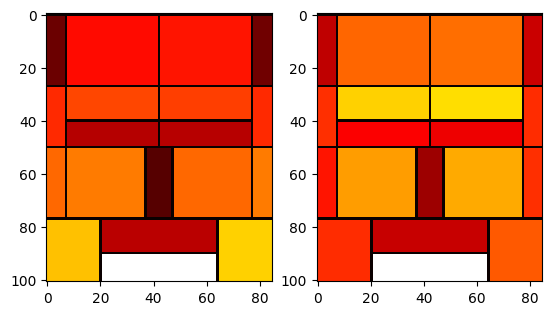

{8: 5518, 19: 10403, 14: 5176, 5: 5401, 2: 4531, 6: 7037, 7: 3770, 15: 6237, 4: 4479, 16: 6435, 3: 4137, 11: 2985, 1: 2837, 9: 7240, 13: 4551, 12: 4477, 10: 3553, 18: 2960, 17: 2313, None: 0}
{8: 6189, 11: 2393, 14: 10644, 19: 15685, 4: 10241, 16: 8207, 1: 2325, 5: 5951, 12: 6704, 2: 6679, 15: 8593, 6: 7373, 7: 3993, 13: 8636, 9: 7181, 17: 1803, 18: 4137, 3: 8153, 10: 4088, None: 0}
{(8, 8): 1291, (14, 19): 1873, (16, 14): 343, (19, 19): 3407, (1, 5): 404, (8, 5): 1123, (12, 2): 56, (15, 6): 1028, (6, 7): 342, (7, 6): 394, (4, 15): 503, (15, 4): 281, (4, 16): 111, (17, 15): 185, (19, 3): 902, (5, 11): 199, (14, 2): 78, (6, 1): 257, (1, 9): 59, (1, 8): 178, (14, 13): 1028, (15, 15): 1170, (11, 11): 317, (12, 12): 301, (19, 2): 363, (2, 1): 240, (6, 10): 527, (16, 3): 69, (8, 9): 374, (10, 12): 125, (12, 8): 265, (5, 5): 1220, (12, 19): 362, (19, 6): 125, (18, 10): 85, (18, 13): 188, (16, 1): 108, (4, 14): 403, (18, 18): 425, (3, 2): 890, (5, 2): 166, (14, 16): 525, (6, 9): 1073, (15, 19

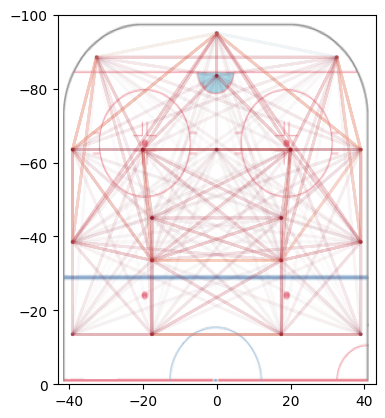

In [86]:
FILENAME = "Linhac24_Sportlogiq" if IS_2024 else "Linhac_df_keyed_20_games"
df = pd.read_csv(filepath_or_buffer=f"{FILENAME}.csv")
"""
Idea: For each pass, we look at when the next shot occurs (or turnover, etc.)
    then we count the number of events till that other event, and then give that
    original event a decayed value for xG

    Then for the zone/bubble that the pass ocurred in, we add the new xG value to it

    Then we normalize by dividing the summed up xGs by the number of passes in that zones
"""

def get_zone(x, y):
    x = abs(x)

    if y > -43 and y < -35 and x < 27 and x > 0:
        return 1
    elif y > -43 and y < -35 and x < 50 and x > 27:
        return 2
    elif y > -43 and y < -35 and x < 77 and x > 50:
        return 3
    elif y > -43 and y < -22 and x > 77:
        return 4
    elif y > -35 and y < 0 and x < 27 and x > 0:
        return 5
    elif y > -35 and y < 0 and x < 40 and x > 27:
        return 6
    elif y > -35 and y < 0 and x < 50 and x > 40:
        return 7
    elif y > 0 and y < 35 and x < 27 and x > 0:
        return 8
    elif y > 0 and y < 35 and x < 40 and x > 27:
        return 9
    elif y > 0 and y < 35 and x < 50 and x > 40:
        return 10
    elif y > 35 and y < 43 and x < 27 and x > 0:
        return 11
    elif y > 35 and y < 43 and x < 50 and x > 27:
        return 12
    elif y > 35 and y < 43 and x < 77 and x > 50:
        return 13
    elif y > 22 and y < 43 and x > 77:
        return 14
    elif x > 50 and x < 77 and y > -35 and y < -5:
        return 15
    elif x > 50 and x < 77 and y > 5 and y < 35:
        return 16
    elif x > 50 and x < 77 and y > -5 and y < 5:
        return 17
    elif y > -22 and y < 22 and x > 77 and x < 90:
        return 18
    elif y > -22 and y < 22 and x > 90:
        return 19
    

def find_next_event():
    n = len(df)
    recv_locations = defaultdict(lambda: 0)
    pass_locations = defaultdict(lambda: 0)
    pass_vectors = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        if row['eventname'] == "pass" and idx != n - 1:
            nextplay = df.iloc[idx + 1]
            nexteventname = nextplay["eventname"]
            if nexteventname == "reception":
                recv_locations[
                    get_zone(
                        (nextplay["xadjcoord"]), 
                        (nextplay["yadjcoord"])
                    )
                ] += 1
                pass_vectors[(
                    get_zone(
                        row["xadjcoord"], 
                        row["yadjcoord"]
                    ),
                    get_zone(
                        nextplay["xadjcoord"], 
                        nextplay["yadjcoord"]
                    ))] += 1
            
            pass_locations[
                get_zone(
                    row["xadjcoord"], 
                    row["yadjcoord"]
                )
            ] += 1
    
    locs = [[pass_locations[get_zone(i, j)] for j in range(-42, 43)] for i in range(0, 101)]
    data = np.array(locs)
    recv_locs = [[recv_locations[get_zone(i, j)] for j in range(-42, 43)] for i in range(0, 101)]
    recv_data = np.array(recv_locs)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(data, cmap='hot', interpolation='nearest')
    ax[1].imshow(recv_data, cmap='hot', interpolation='nearest')
    plt.show()

    return (recv_locations, pass_locations, pass_vectors)

def map_passing_zones(pass_vectors: dict):
    zone_dict = {
        1: (13.5, -39),
        2: (38.5, -39),
        3: (63.5, -39),
        4: (88.5, -32.5),
        5: (13.5, -17.5),
        6: (33.5, -17.5),
        7: (45, -17.5),
        8: (13.5, 17.5),
        9: (33.5, 17.5),
        10: (45, 17.5),
        11: (13.5, 39),
        12: (38.5, 39),
        13: (63.5, 39),
        14: (88.5, 32.5),
        15: (63.5, -20),
        16: (63.5, 20),
        17: (63.5, 0),
        18: (83.5, 0),
        19: (95, 0),
    }

    zone_dict = {
        zone: (loc[1], -loc[0]) for zone, loc in zone_dict.items()
    }

    return {
        tuple(chain(*(zone_dict[zones[0]], zone_dict[zones[1]]))): freq
        for zones, freq in pass_vectors.items()
    }

res, pl, pv = find_next_event()
print(dict(res))
print(dict(pl))
print(dict(pv))
zones_dict = (map_passing_zones(dict(pv)))

def map_vectors(data):
    # Extract coordinates and frequencies
    x1_list = []
    y1_list = []
    x2_list = []
    y2_list = []
    frequency_list = []

    for (x1, y1, x2, y2), freq in data.items():
        x1_list.append(x1)
        y1_list.append(y1)
        x2_list.append(x2)
        y2_list.append(y2)
        frequency_list.append(freq)

    # Normalize frequencies
    min_freq = min(frequency_list)
    max_freq = max(frequency_list)
    norm = plt.Normalize(min_freq, max_freq)

    # Plot arrows with color and opacity based on frequency
    for i in range(len(x1_list)):
        color = plt.cm.RdBu(norm(frequency_list[i]))
        plt.arrow(x1_list[i], y1_list[i], x2_list[i] - x1_list[i], y2_list[i] - y1_list[i],
                head_width=0.1, head_length=0.2, linewidth=2, color=color, alpha=frequency_list[i]/max_freq)

    img = imread("hockey_rink.png")
    plt.imshow(img, extent=[-42.5, 42.5, -100, 0], alpha=0.5)  # adjust extent based on image size and scale


    # Set axis limits
    plt.xlim(-43, 43)
    plt.ylim(-100, 0)
    plt.gca().invert_yaxis()

    # Show plot
    plt.show()


map_vectors(zones_dict)

In [87]:
def get_current_zone(x):
    return 0 if x >= 25 else (1 if x >= -25 and x < 25 else 2)

def is_ozone(x):
    return get_current_zone(x) == 0

def get_ozone_times(full_data: pd.DataFrame):
    full_data = full_data[full_data["teaminpossession"].notna()]
    games = sorted(full_data['gameid'].unique())
    gameDict = {}
    xg_key = 'xg_allattempts' if IS_2024 else 'xg'
    for game in games:
        game_df = full_data.loc[full_data['gameid'] == game].reset_index()
        ozone_event_started = False
        ozone_start_time = 0
        ozone_counts = defaultdict(list)
        cumul_xg = 0
        prevTeam = None
        for i, event in game_df.iterrows():
            if i == 0:
                prevTeam = event["teaminpossession"]
                continue

            currTeam = event["teaminpossession"]
            currTime = event["compiledgametime"]
            ozone_predicate = is_ozone(event['xadjcoord'])

            if not pd.isna(event[xg_key]):
                cumul_xg += event[xg_key]

            if currTeam == prevTeam and ozone_predicate:
                if not ozone_event_started:
                     ozone_start_time = currTime
            
                ozone_event_started = True
            elif not ozone_event_started:
                prevTeam = currTeam
                continue
            else:
                ozone_counts[prevTeam].append((currTime - ozone_start_time, cumul_xg))
                ozone_event_started = False
                cumul_xg = 0
            
            prevTeam = currTeam
        gameDict[game] = ozone_counts
    
    return gameDict
gameDict = get_ozone_times(df)

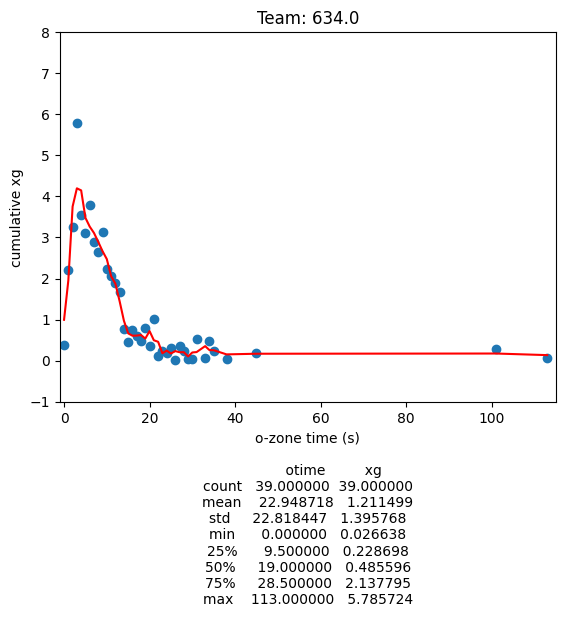

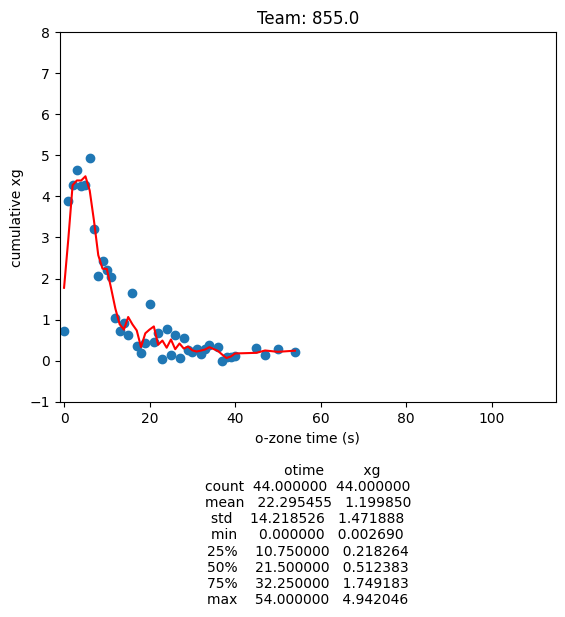

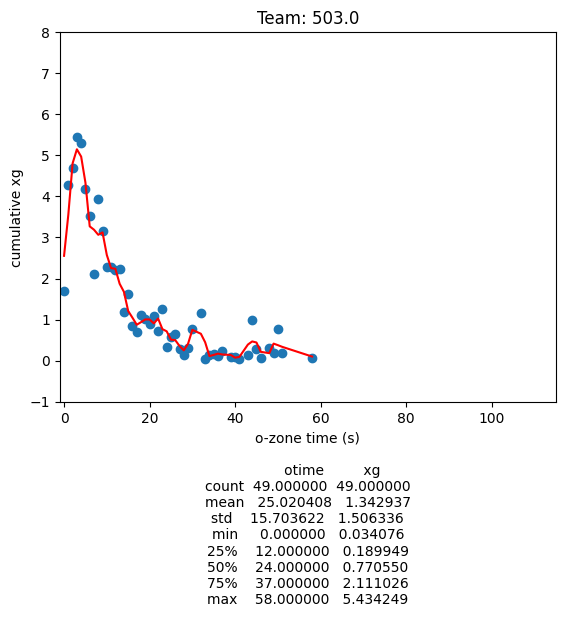

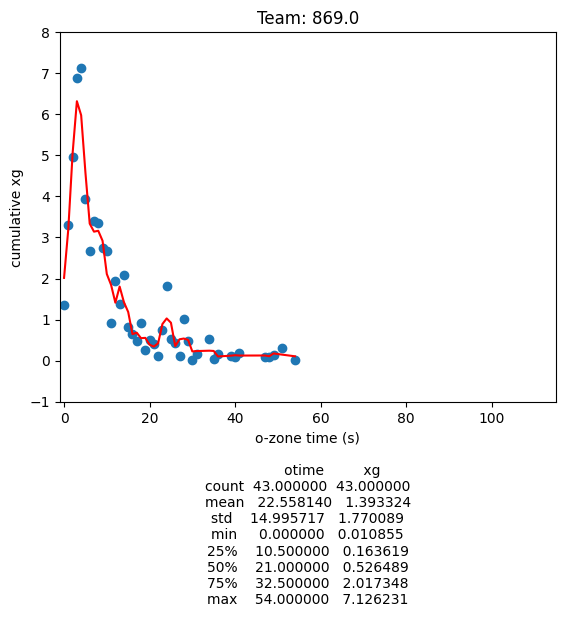

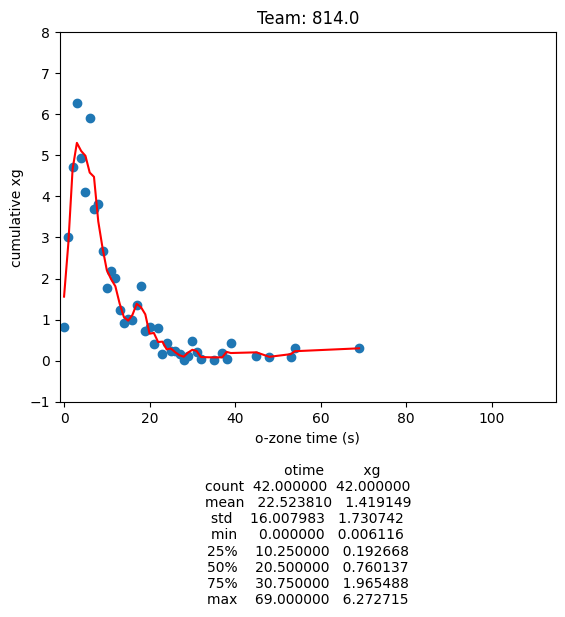

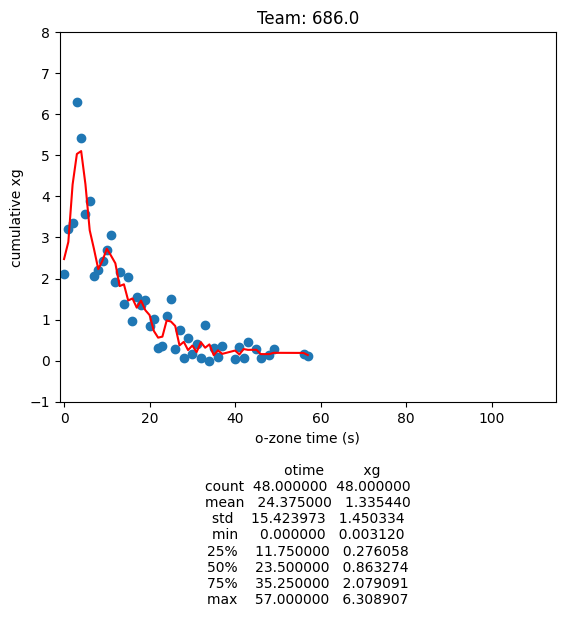

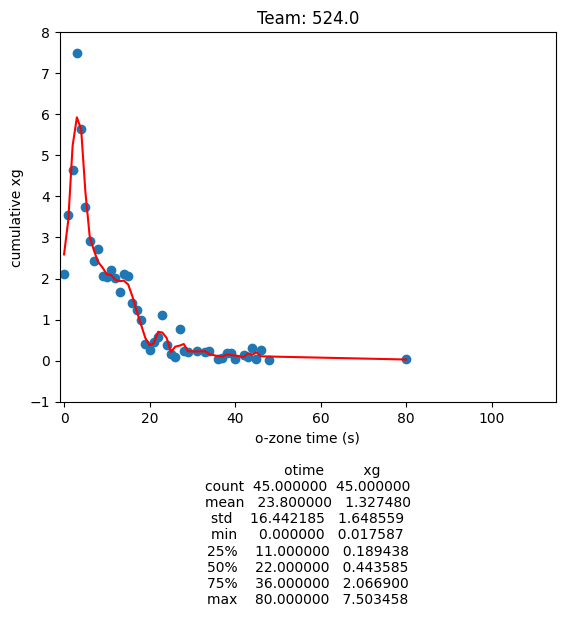

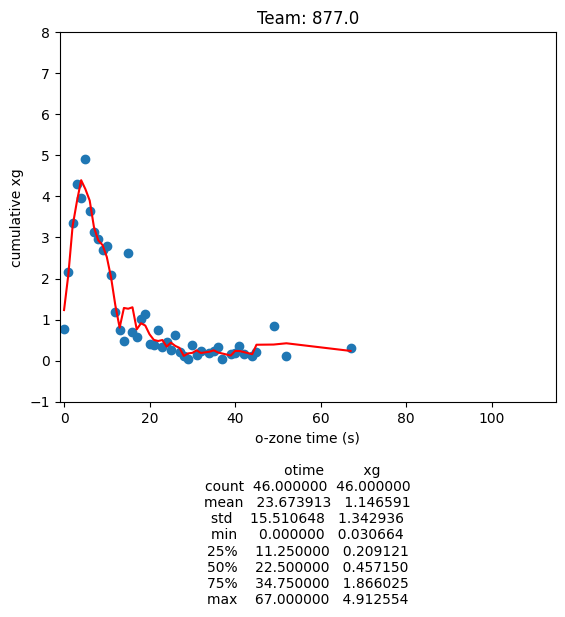

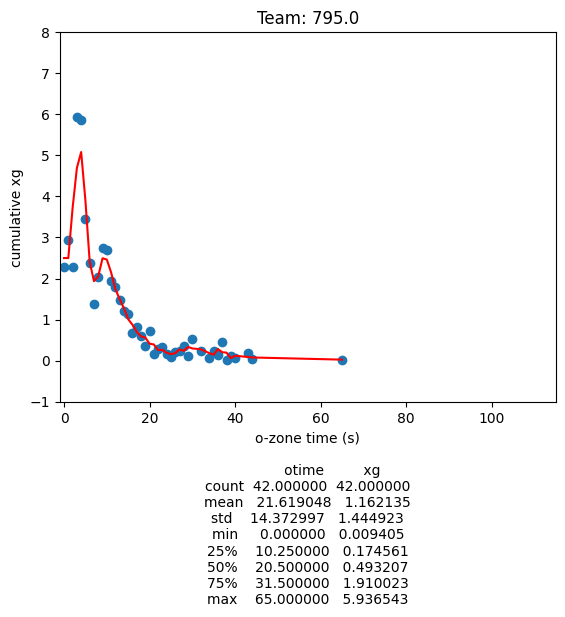

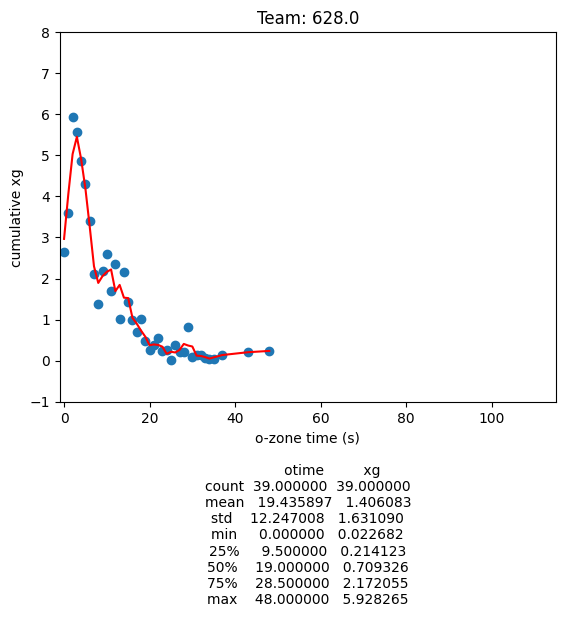

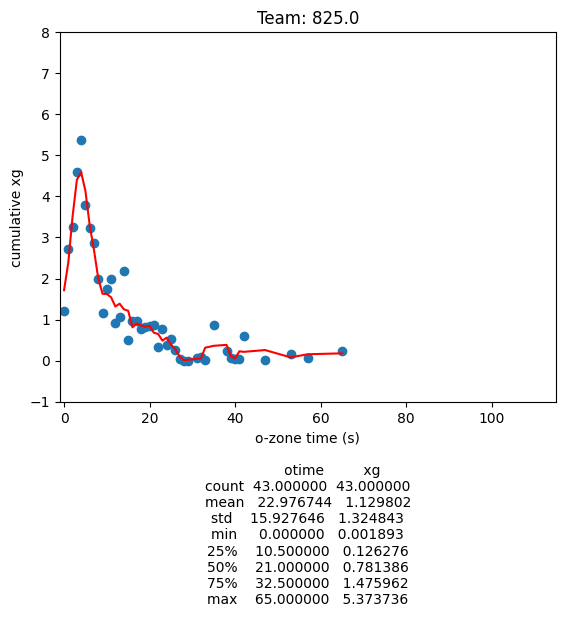

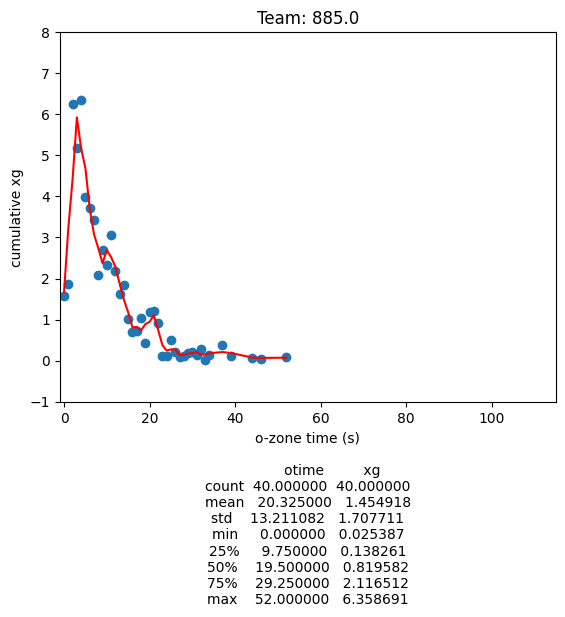

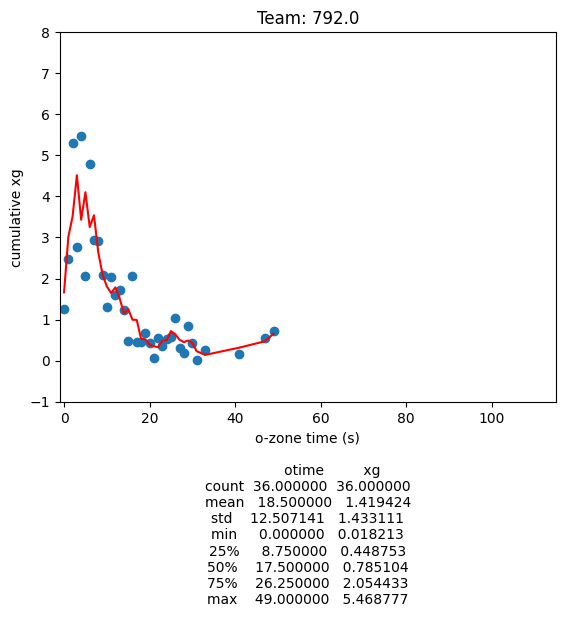

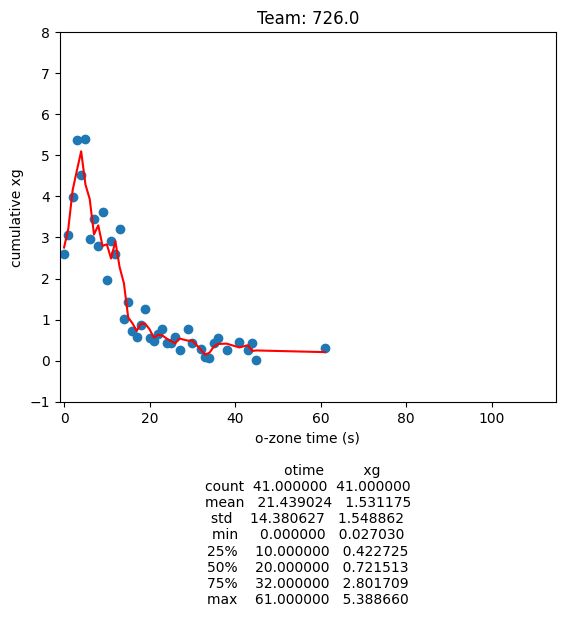

Total Stats
            otime          xg
count  597.000000  597.000000
mean    22.378559    1.316996
std     15.402238    1.522242
min      0.000000    0.001893
25%     10.000000    0.217862
50%     21.000000    0.659115
75%     32.000000    2.069175
max    113.000000    7.503458


In [88]:
def collapseCumulXGCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        factor = 1
        totals[round(otime * factor, 0) / factor] += xg
    
    return [[otime, xg] for otime, xg in totals.items()]

teamCount = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamCount[team].extend([[otime, xg] for otime, xg in gameDict[game][team] if xg != 0])

memoizedCumulxg = []
windowSize = 3
for team in teamCount:
    dataArr = collapseCumulXGCount(teamCount[team])
    memoizedCumulxg = memoizedCumulxg + dataArr

    data = np.array(sorted(dataArr, key=lambda x: x[0]))
    paddedData = np.pad([y[1] for y in (data)], (windowSize//2, windowSize-1-windowSize//2), mode='edge')
    ma_vec = np.convolve(paddedData, np.ones((windowSize,))/windowSize, mode='valid')
    description = pd.DataFrame(dataArr, columns=["otime", "xg"]).describe()

    plt.title(f"Team: {team}")
    plt.scatter([x[0] for x in data], [y[1] for y in data])
    plt.plot([x[0] for x in data], ma_vec, "r")
    plt.xlim(-1, 115)
    plt.ylim(-1, 8)
    plt.xlabel(f"o-zone time (s)\n\n{description}")
    plt.ylabel("cumulative xg")
    plt.show()

cumulxg_df = pd.DataFrame(memoizedCumulxg, columns=["otime", "xg"]).describe()
print(f'Total Stats\n{cumulxg_df}')


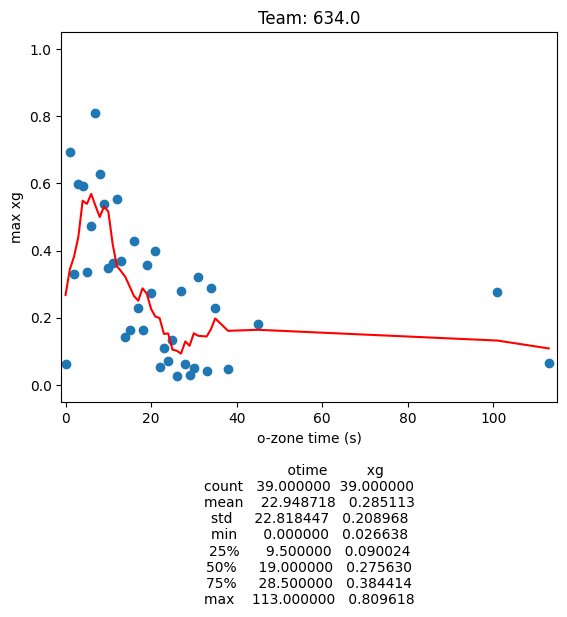

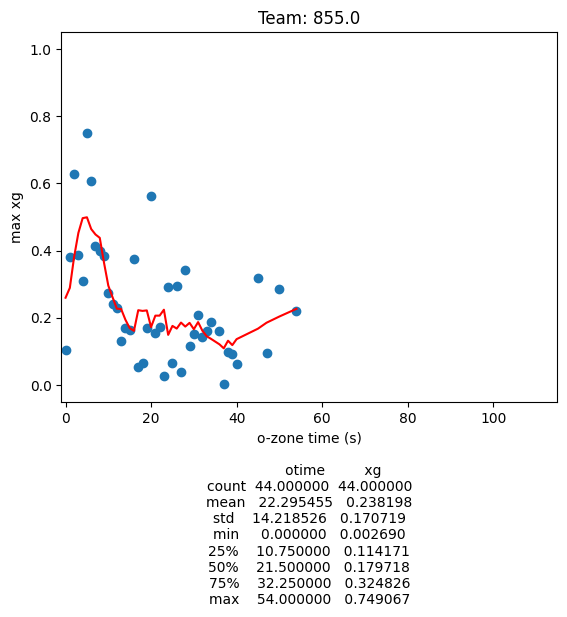

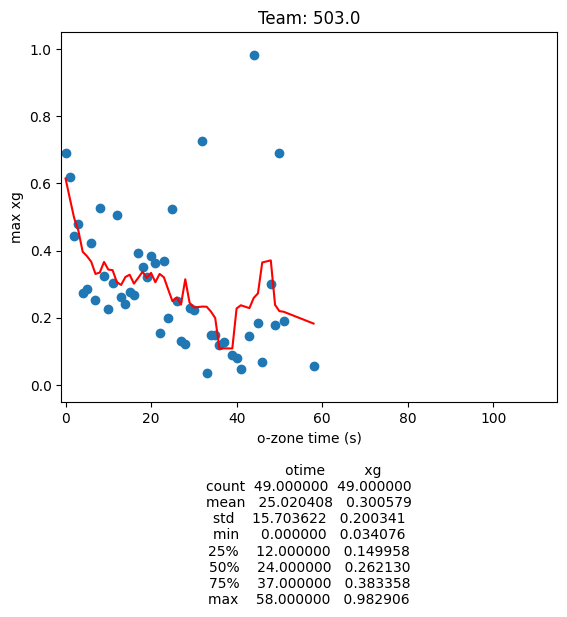

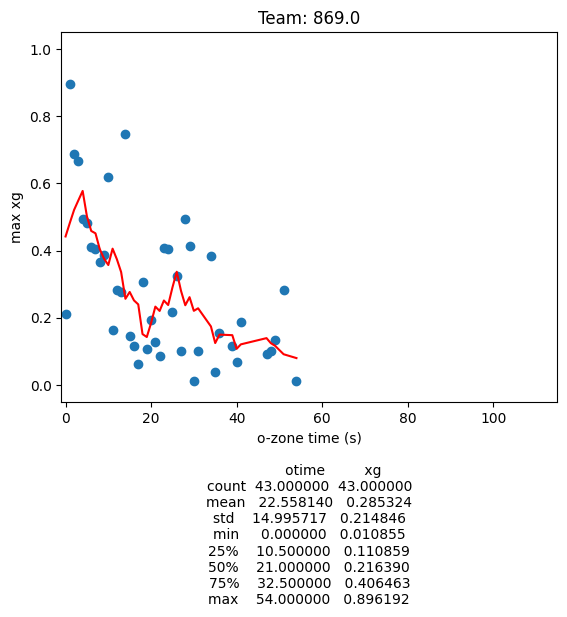

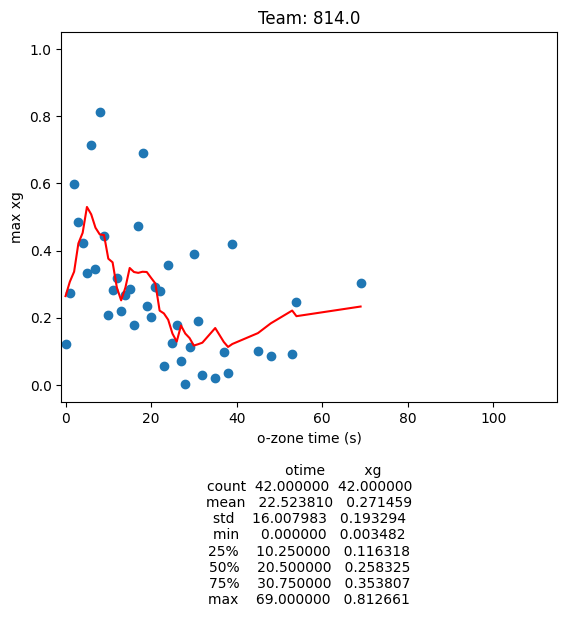

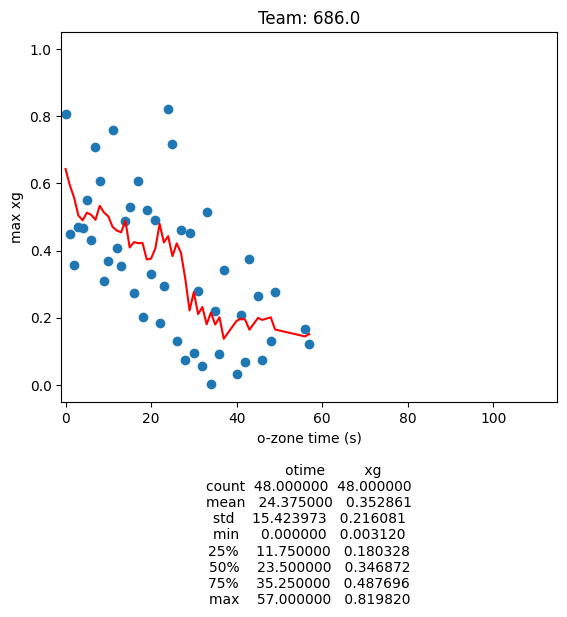

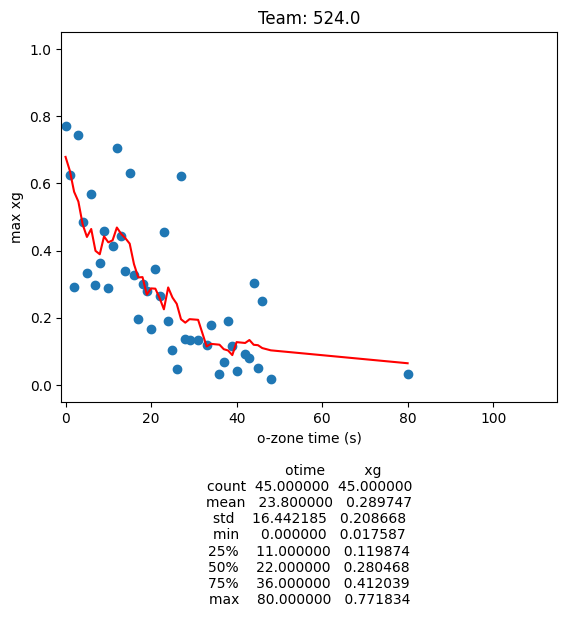

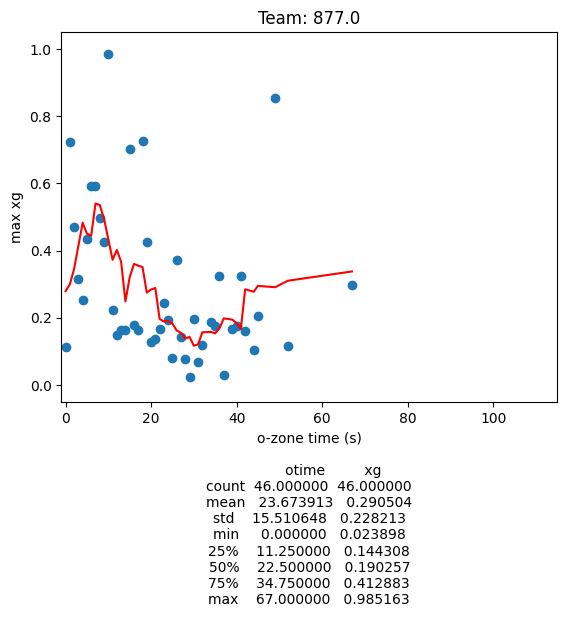

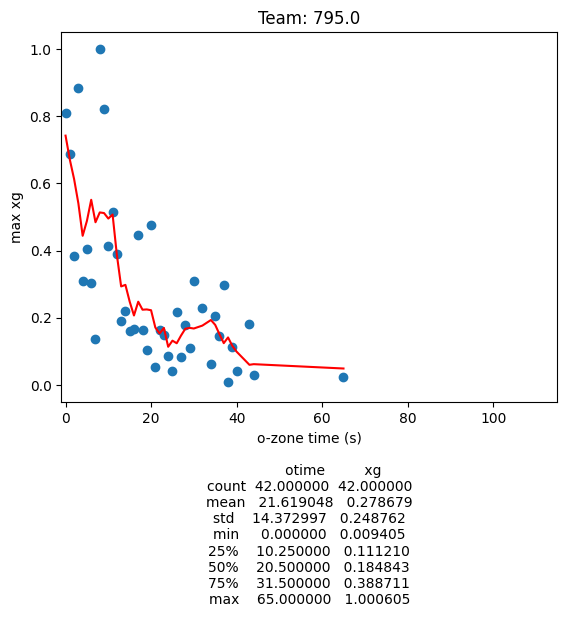

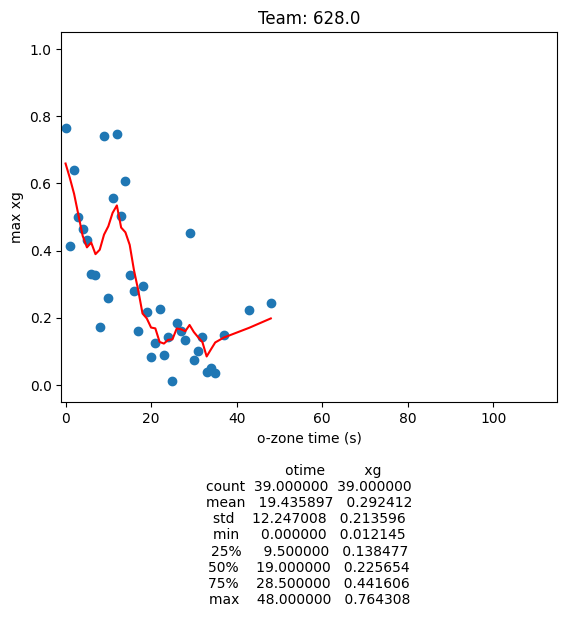

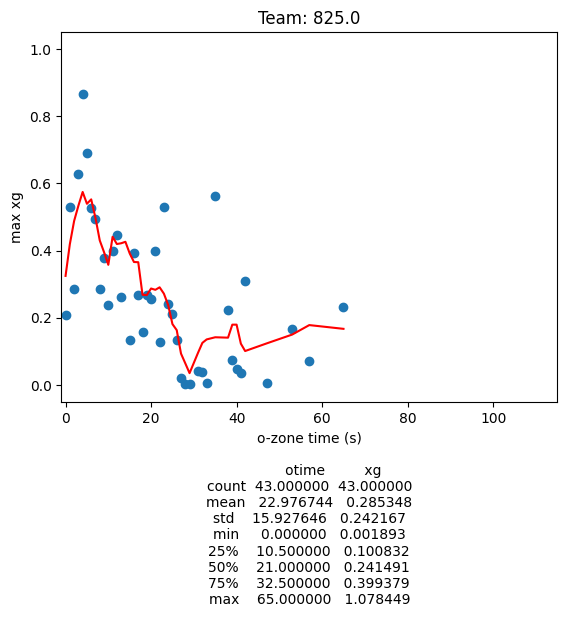

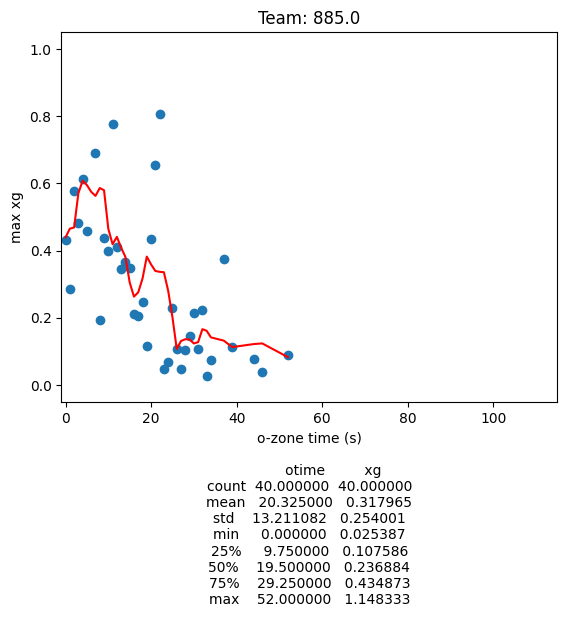

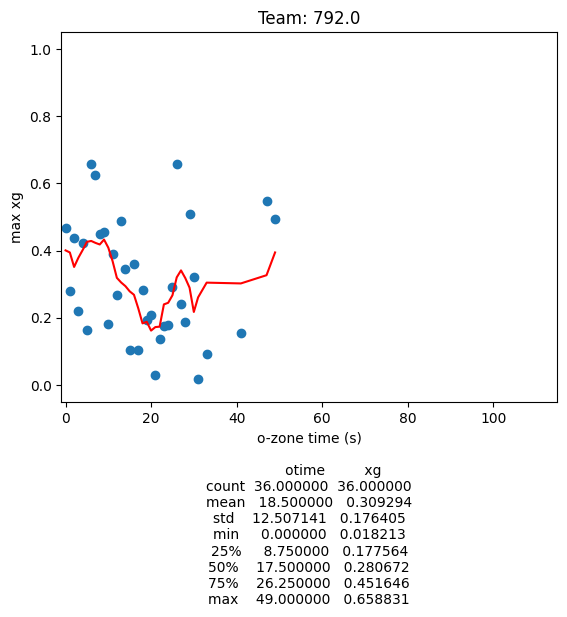

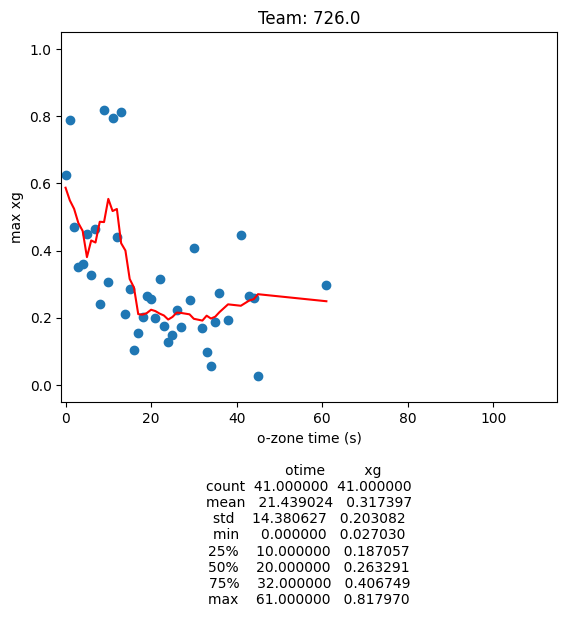

Total Stats
            otime          xg
count  597.000000  597.000000
mean    22.378559    0.294109
std     15.402238    0.213449
min      0.000000    0.001893
25%     10.000000    0.131952
50%     21.000000    0.251190
75%     32.000000    0.412057
max    113.000000    1.148333


In [89]:
def collapseMaxXGCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        factor = 1
        totals[round(otime * factor, 0) / factor] = max(xg, totals[round(otime, 0)])
    
    return [[otime, xg] for otime, xg in totals.items()]

teamCount = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamCount[team].extend([[otime, xg] for otime, xg in gameDict[game][team] if xg != 0])

memoizedMaxxg = []
windowSize = 7
for team in teamCount:
    dataArr = collapseMaxXGCount(teamCount[team])
    memoizedMaxxg = memoizedMaxxg + dataArr

    data = np.array(sorted(dataArr, key=lambda x: x[0]))
    paddedData = np.pad([y[1] for y in (data)], (windowSize//2, windowSize-1-windowSize//2), mode='edge')
    ma_vec = np.convolve(paddedData, np.ones((windowSize,))/windowSize, mode='valid')
    description = pd.DataFrame(dataArr, columns=["otime", "xg"]).describe()

    plt.title(f"Team: {team}")
    plt.scatter([x[0] for x in data], [y[1] for y in data])
    plt.plot([x[0] for x in data], ma_vec, "r")
    plt.xlim(-1, 115)
    plt.ylim(-0.05, 1.05)
    plt.xlabel(f"o-zone time (s)\n\n{description}")
    plt.ylabel("max xg")
    plt.show()

cumulxg_df = pd.DataFrame(memoizedMaxxg, columns=["otime", "xg"]).describe()
print(f'Total Stats\n{cumulxg_df}')


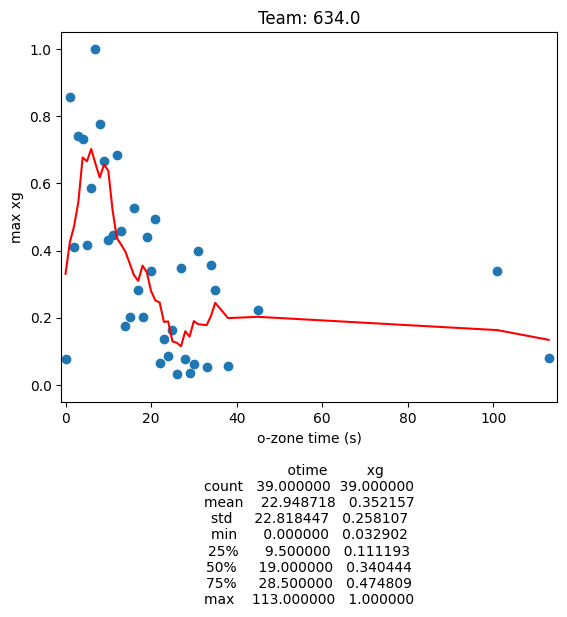

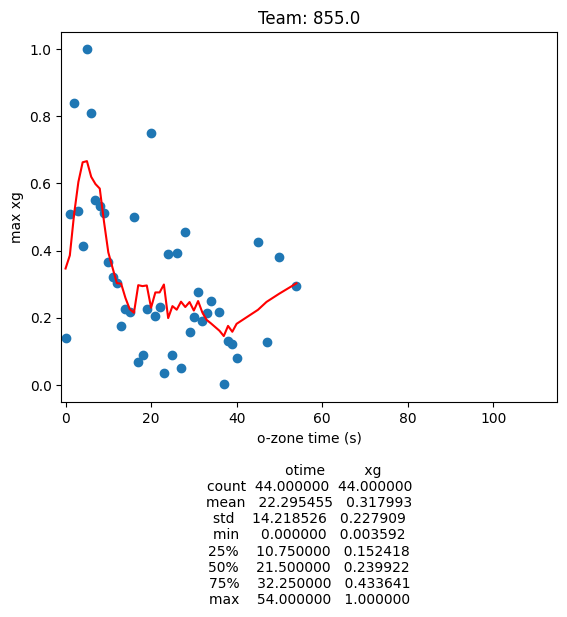

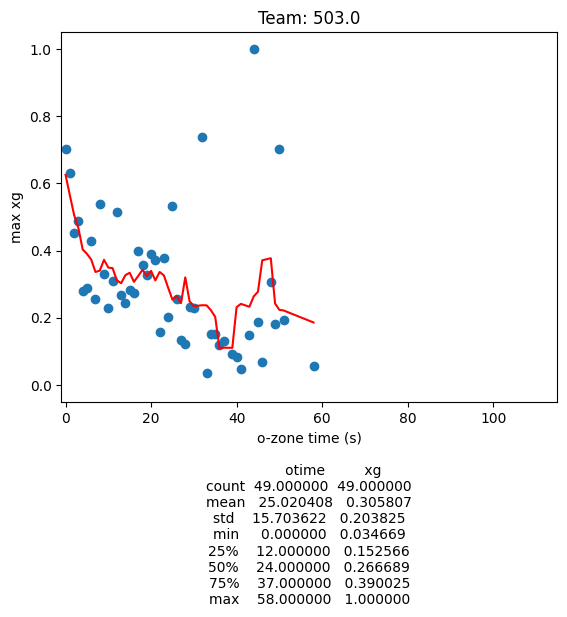

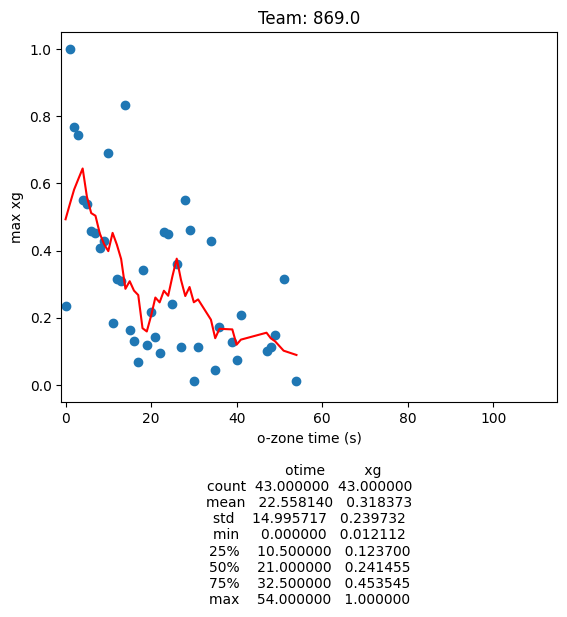

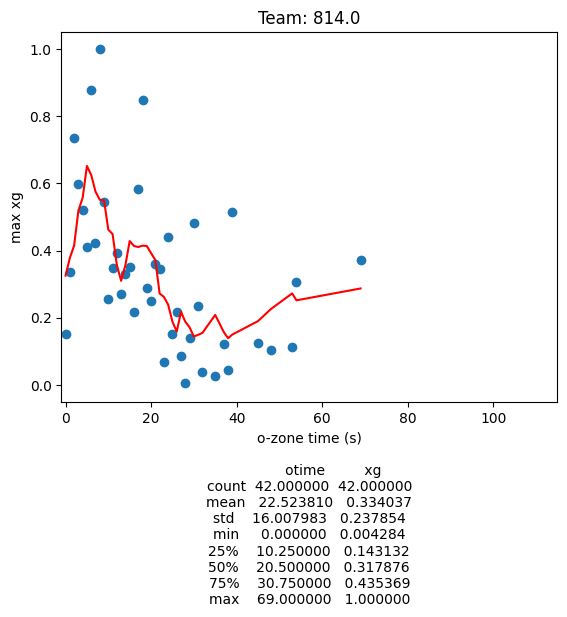

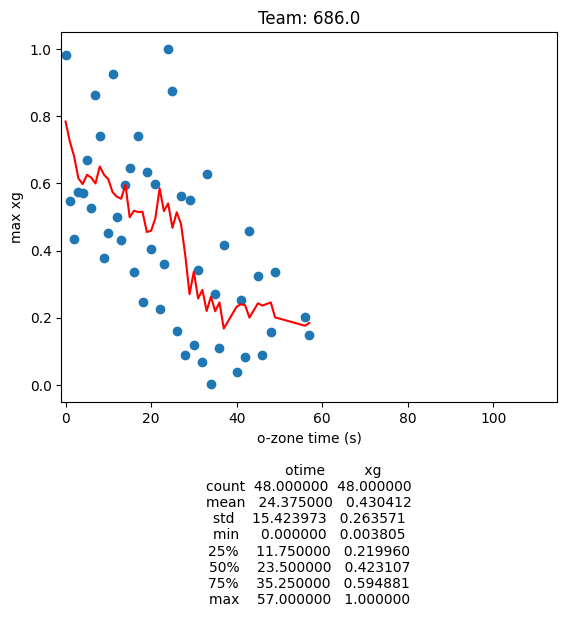

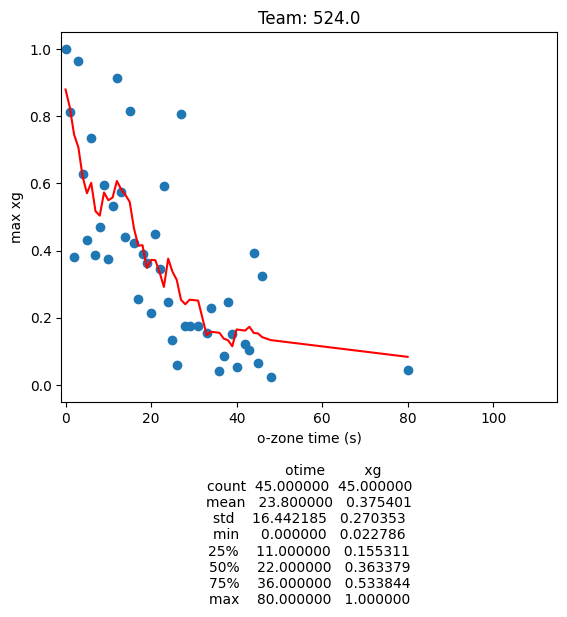

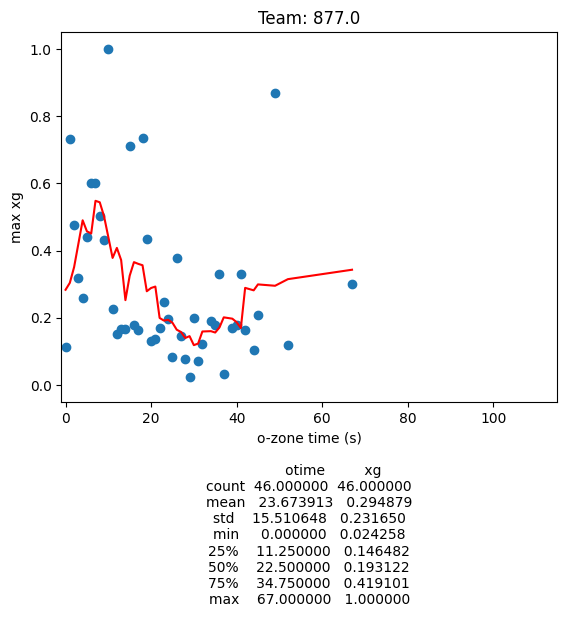

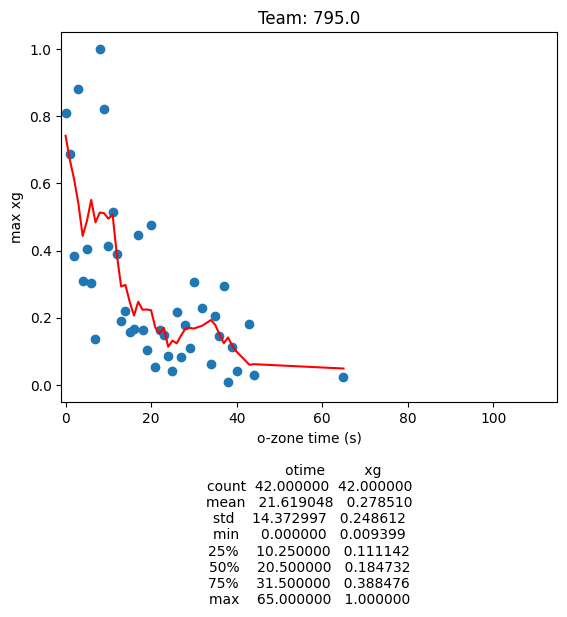

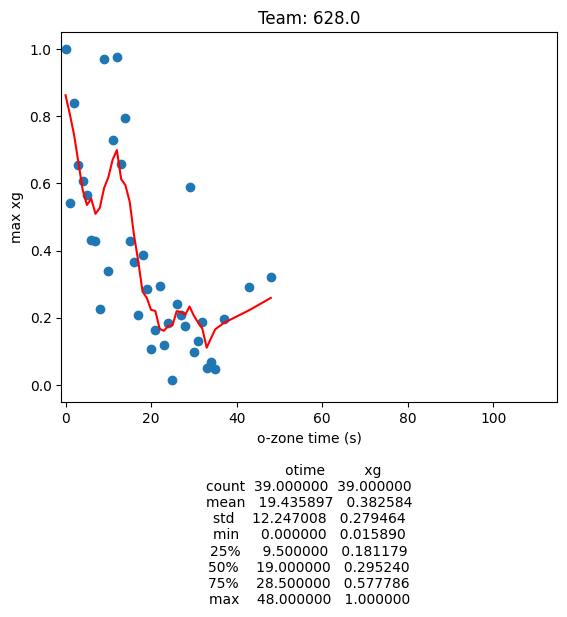

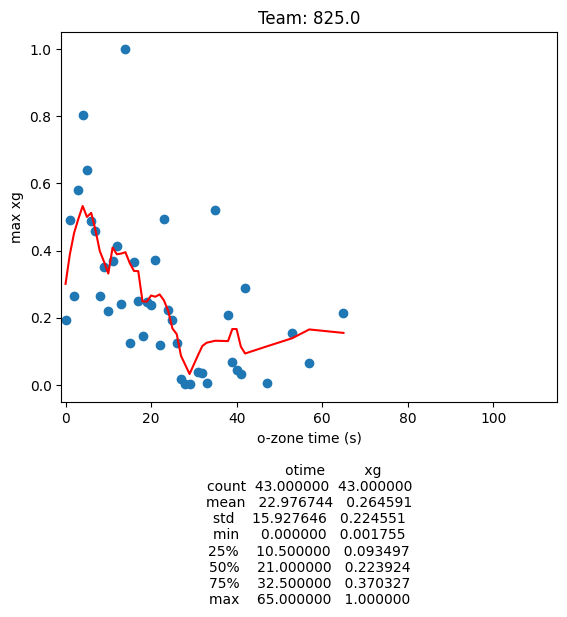

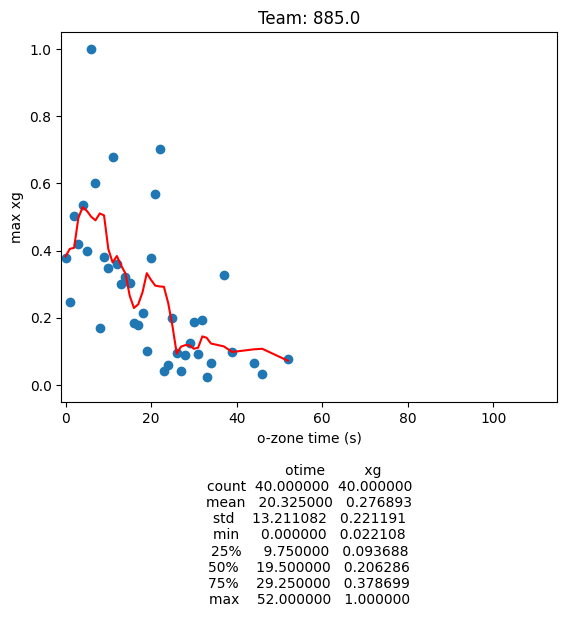

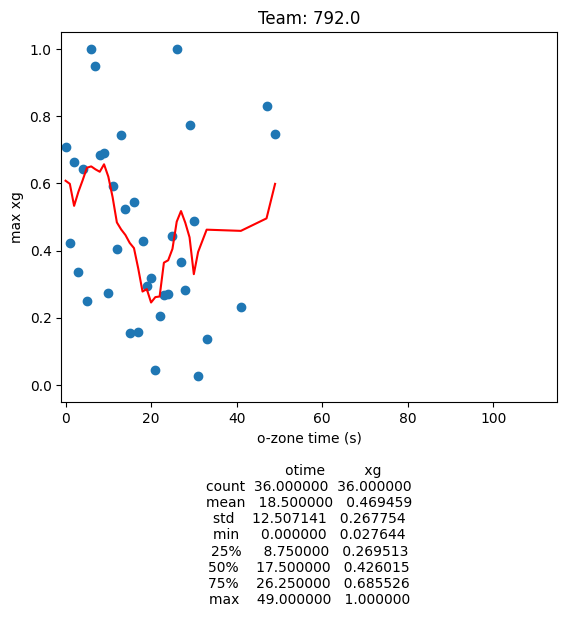

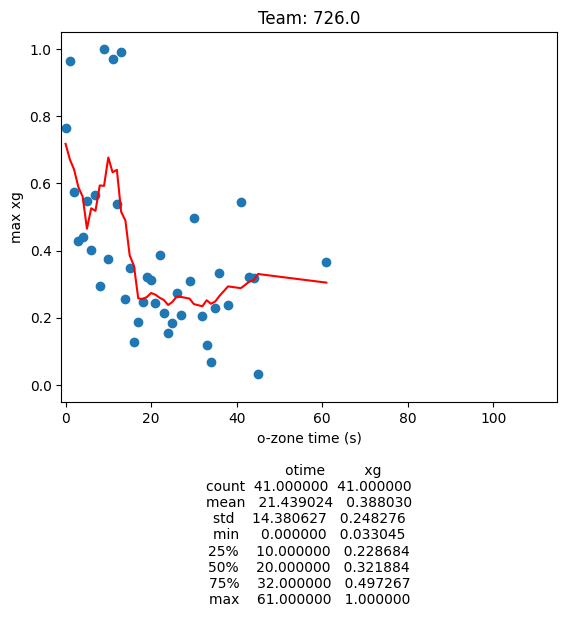

Total Stats
            otime          xg
count  597.000000  597.000000
mean    22.378559    0.340751
std     15.402238    0.248723
min      0.000000    0.001755
25%     10.000000    0.150998
50%     21.000000    0.287361
75%     32.000000    0.470613
max    113.000000    1.000000


In [90]:
def collapseNormalizedXGCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        factor = 1
        totals[round(otime * factor, 0) / factor] = max(xg, totals[round(otime, 0)])
    
    maxSeen = max([val for val in totals.values()])
    return [[otime, (xg / maxSeen)] for otime, xg in totals.items()]

teamCount = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamCount[team].extend([[otime, xg] for otime, xg in gameDict[game][team] if xg != 0])

memoizedNormxg = []
windowSize = 7
for team in teamCount:
    dataArr = collapseNormalizedXGCount(teamCount[team])
    memoizedNormxg = memoizedNormxg + dataArr

    data = np.array(sorted(dataArr, key=lambda x: x[0]))
    description = pd.DataFrame(dataArr, columns=["otime", "xg"]).describe()
    paddedData = np.pad([y[1] for y in (data)], (windowSize//2, windowSize-1-windowSize//2), mode='edge')
    ma_vec = np.convolve(paddedData, np.ones((windowSize,))/windowSize, mode='valid')

    plt.title(f"Team: {team}")
    plt.scatter([x[0] for x in data], [y[1] for y in data])
    plt.plot([x[0] for x in data], ma_vec, "r")
    plt.xlim(-1, 115)
    plt.ylim(-0.05, 1.05)
    plt.xlabel(f"o-zone time (s)\n\n{description}")
    plt.ylabel("max xg")
    plt.show()

cumulxg_df = pd.DataFrame(memoizedNormxg, columns=["otime", "xg"]).describe()
print(f'Total Stats\n{cumulxg_df}')

In [91]:
ADVANTAGEOUS_EVENTS = ["shot", "penaltydrawn"]
def is_advantageous(x):
    return x in ADVANTAGEOUS_EVENTS

def get_ozone_events(full_data: pd.DataFrame):
    full_data = full_data[full_data["teaminpossession"].notna()]
    games = sorted(full_data['gameid'].unique())
    gameDict = {}
    for game in games:
        game_df = full_data.loc[full_data['gameid'] == game].reset_index()
        ozone_event_started = False
        ozone_start_time = 0
        ozone_counts = defaultdict(list)
        cumul_events_dict = defaultdict(lambda: 0)
        prevTeam = None
        for i, event in game_df.iterrows():
            if i == 0:
                prevTeam = event["teaminpossession"]
                continue

            currTeam = event["teaminpossession"]
            currTime = event["compiledgametime"]
            ozone_predicate = is_ozone(event['xadjcoord'])
            currEventName = event["eventname"]

            if is_advantageous(currEventName):
                cumul_events_dict[currEventName] += 1

            if currTeam == prevTeam and ozone_predicate:
                if not ozone_event_started:
                     ozone_start_time = currTime
            
                ozone_event_started = True
            elif not ozone_event_started:
                prevTeam = currTeam
                continue
            else:
                ozone_counts[prevTeam].append((currTime - ozone_start_time, cumul_events_dict))
                ozone_event_started = False
                cumul_events_dict = defaultdict(lambda: 0)
            
            prevTeam = currTeam
        gameDict[game] = ozone_counts
    
    return gameDict
gameDictEvents = get_ozone_events(df)

Total Stats
            otime      events
count  608.000000  608.000000
mean    22.748355   26.802632
std     15.556693   29.381385
min      0.000000    0.000000
25%     10.000000    4.000000
50%     21.000000   13.000000
75%     33.000000   46.000000
max    113.000000  124.000000
Total Stats
            otime      events
count  608.000000  608.000000
mean    22.748355    1.223684
std     15.556693    3.388025
min      0.000000    0.000000
25%     10.000000    0.000000
50%     21.000000    0.000000
75%     33.000000    1.000000
max    113.000000   28.000000


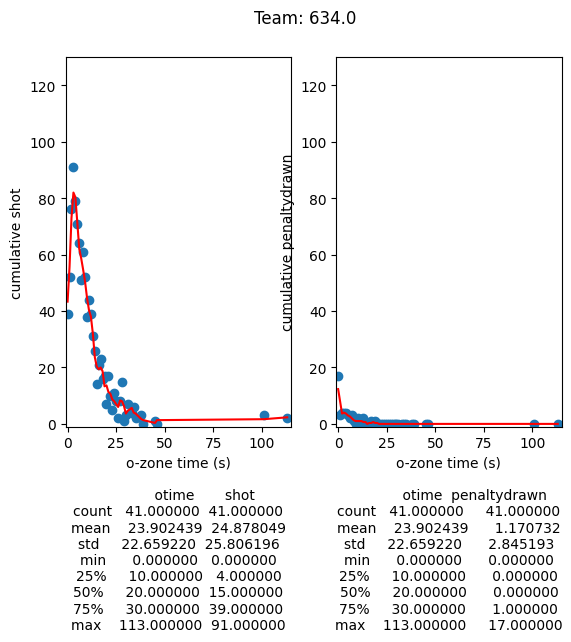

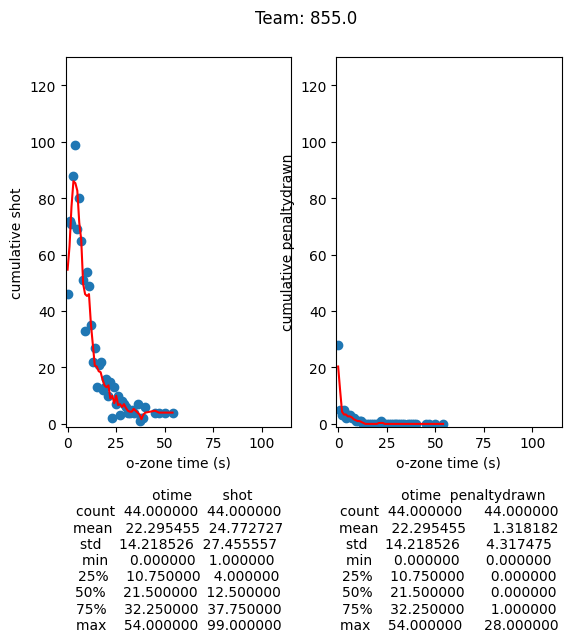

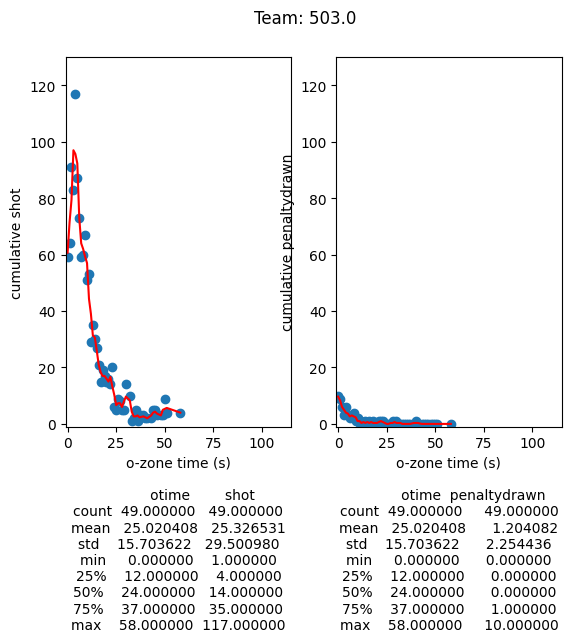

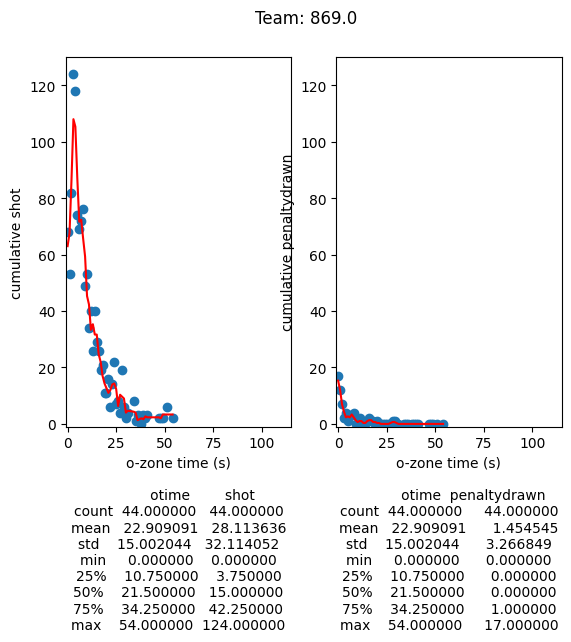

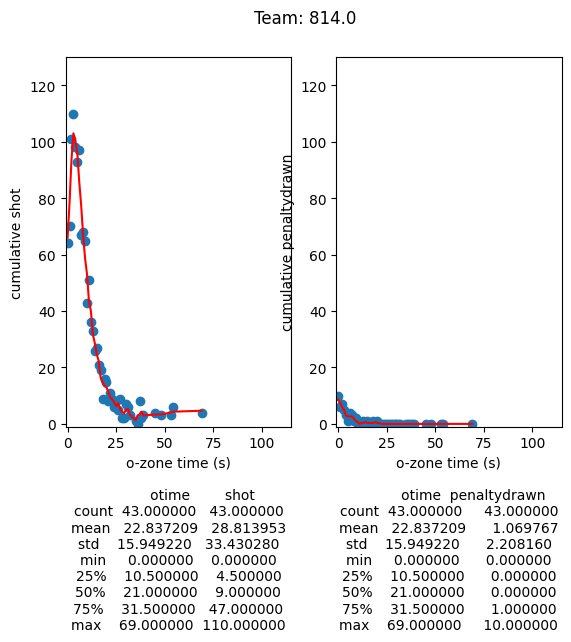

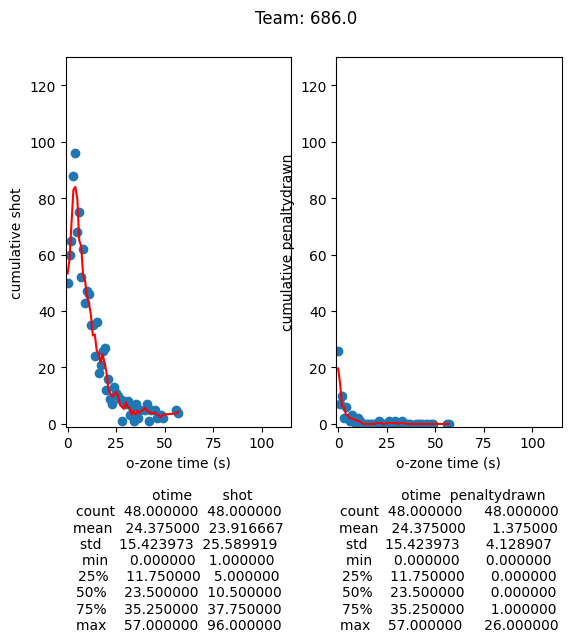

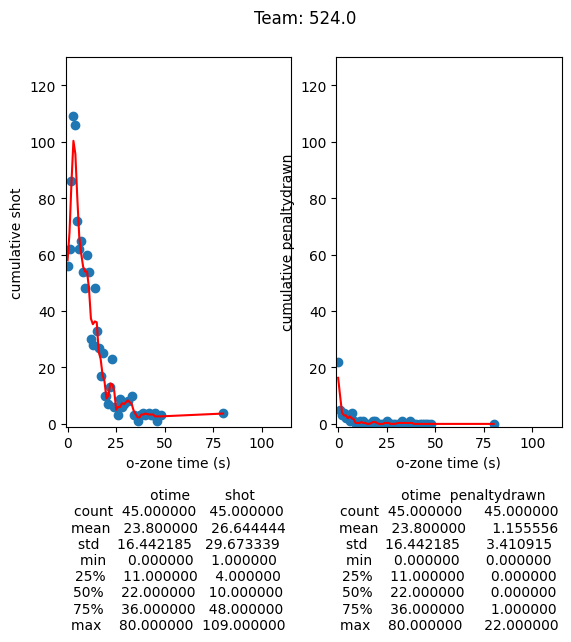

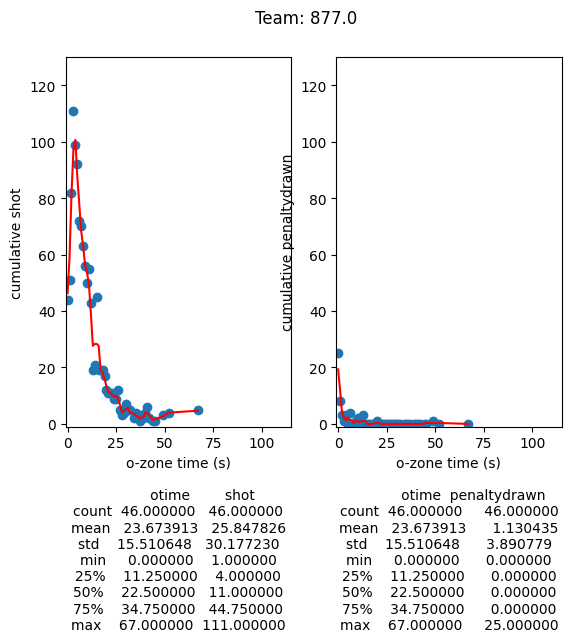

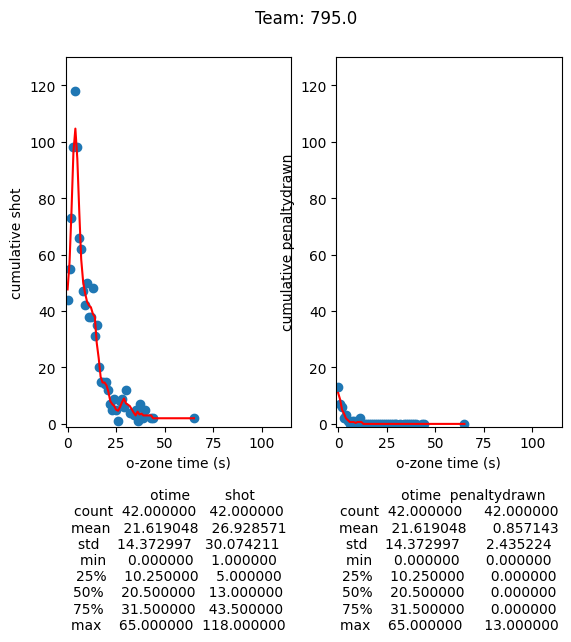

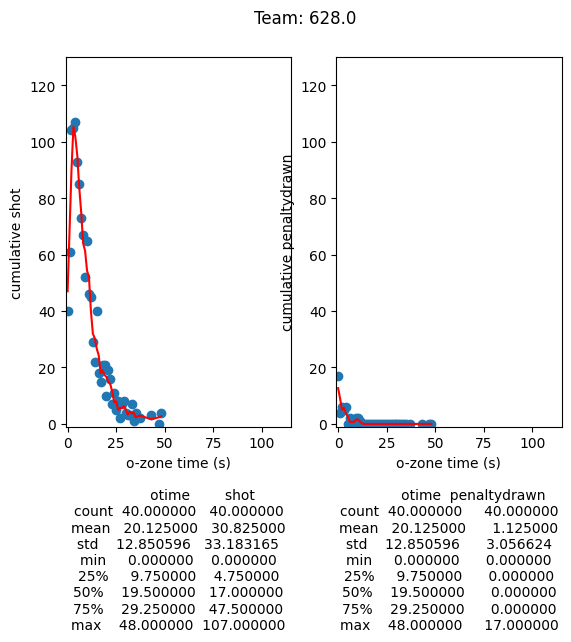

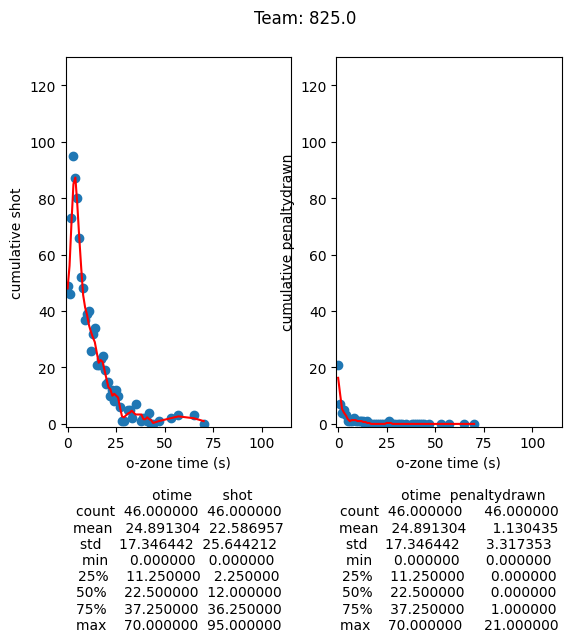

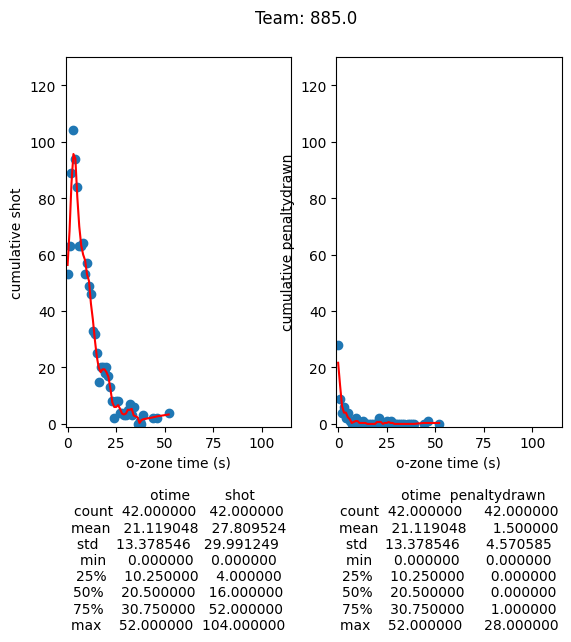

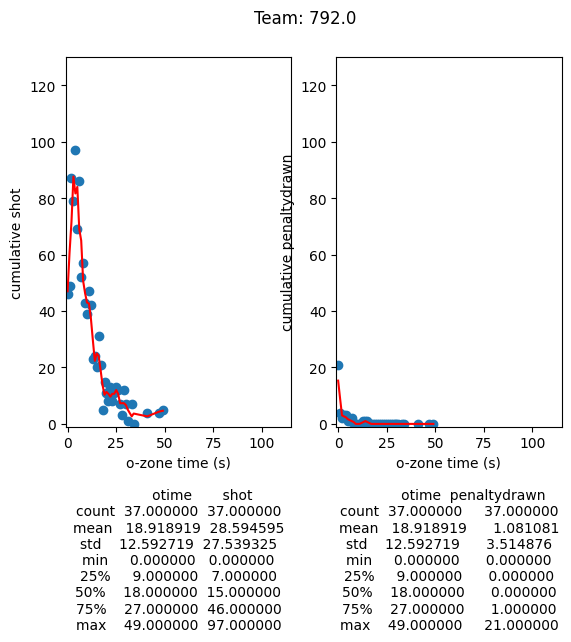

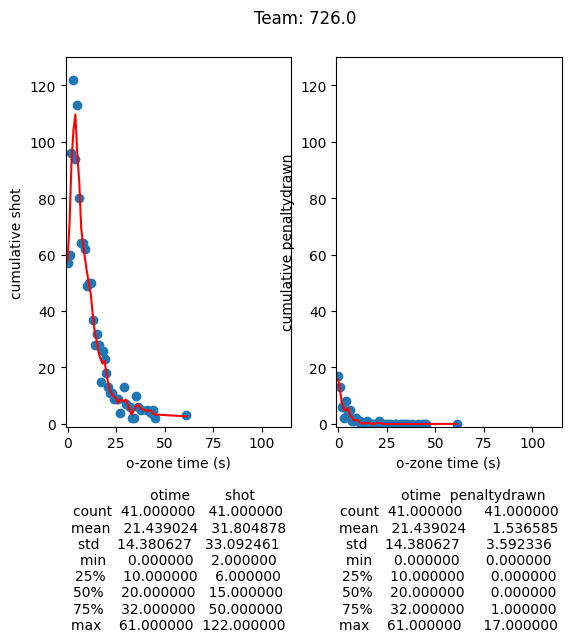

In [92]:
def collapseCumulEventCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        factor = 1
        totals[round(otime * factor, 0) / factor] += xg
    
    return [[otime, xg] for otime, xg in totals.items()]

teamCount = defaultdict(lambda: defaultdict(list))
for game in gameDict:
    for team in gameDict[game]:
        for event_type in ADVANTAGEOUS_EVENTS:
            teamCount[team][event_type].extend([[otime, xg[event_type]] for otime, xg in gameDictEvents[game][team] if xg != 0])

memoizedCumulxg = defaultdict(list)
windowSize = 3
for team in teamCount:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"Team: {team}")
    for idx, event_type in enumerate(ADVANTAGEOUS_EVENTS):
        dataArr = collapseCumulEventCount(teamCount[team][event_type])
        memoizedCumulxg[event_type] = memoizedCumulxg[event_type] + dataArr

        data = np.array(sorted(dataArr, key=lambda x: x[0]))
        description = pd.DataFrame(dataArr, columns=["otime", event_type]).describe()
        paddedData = np.pad([y[1] for y in (data)], (windowSize//2, windowSize-1-windowSize//2), mode='edge')
        ma_vec = np.convolve(paddedData, np.ones((windowSize,))/windowSize, mode='valid')

        axs[idx].scatter([x[0] for x in data], [y[1] for y in data])
        axs[idx].plot([x[0] for x in data], ma_vec, "r")
        axs[idx].set_xlim(-1, 115)
        axs[idx].set_ylim(-1,130)
        axs[idx].set_xlabel(f"o-zone time (s)\n\n{description}")
        axs[idx].set_ylabel(f"cumulative {event_type}")

for event_type in ADVANTAGEOUS_EVENTS:
    cumulxg_df = pd.DataFrame(memoizedCumulxg[event_type], columns=["otime", "events"]).describe()
    print(f'Total Stats\n{cumulxg_df}')


Total Stats
            otime      events
count  608.000000  608.000000
mean    22.748355    2.407895
std     15.556693    0.873217
min      0.000000    0.000000
25%     10.000000    2.000000
50%     21.000000    2.000000
75%     33.000000    3.000000
max    113.000000    6.000000
Total Stats
            otime      events
count  608.000000  608.000000
mean    22.748355    0.324013
std     15.556693    0.471894
min      0.000000    0.000000
25%     10.000000    0.000000
50%     21.000000    0.000000
75%     33.000000    1.000000
max    113.000000    2.000000


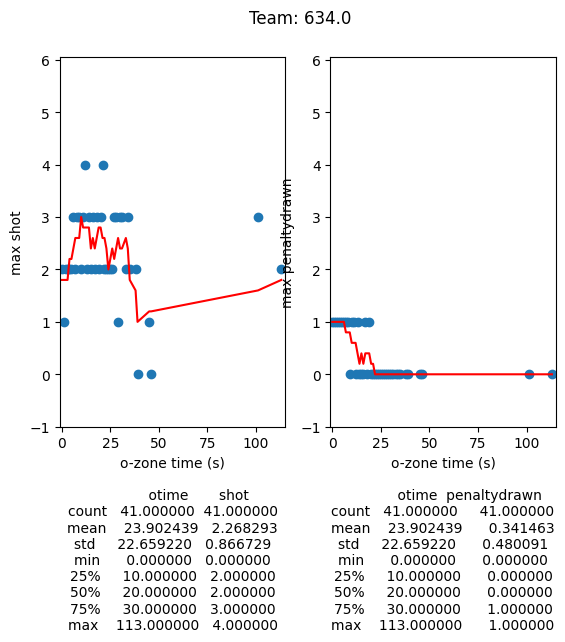

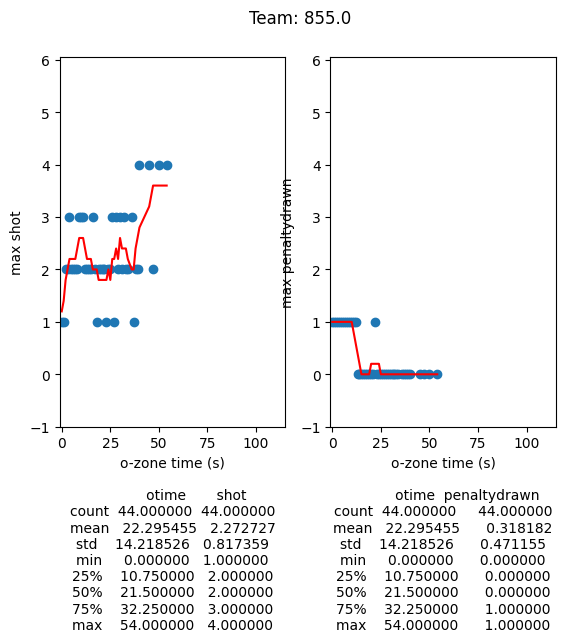

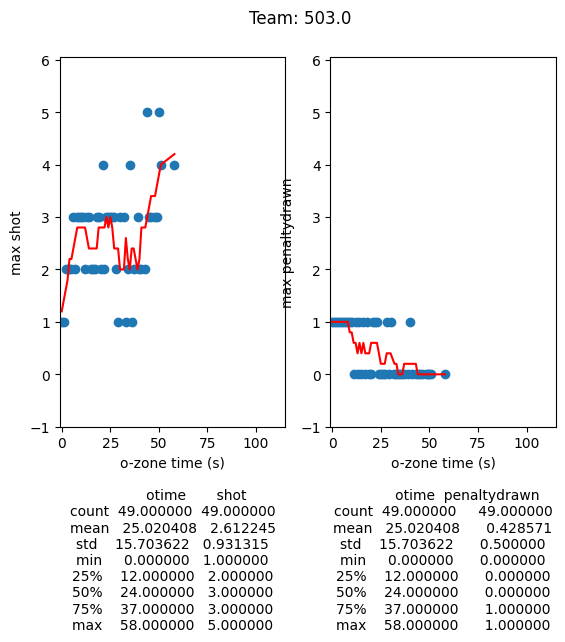

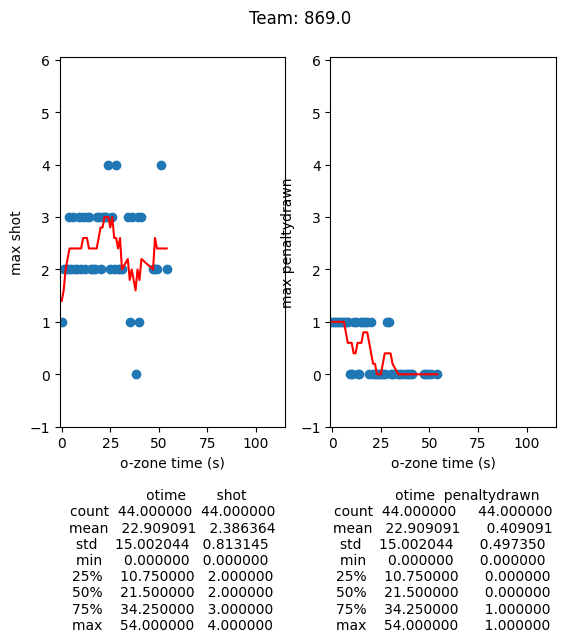

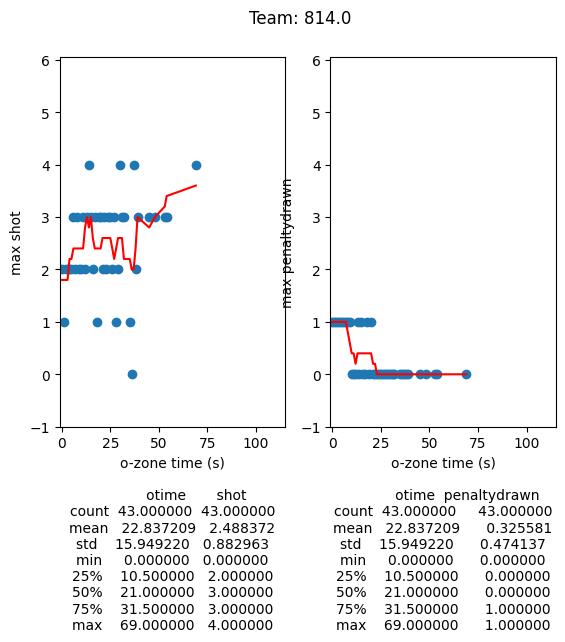

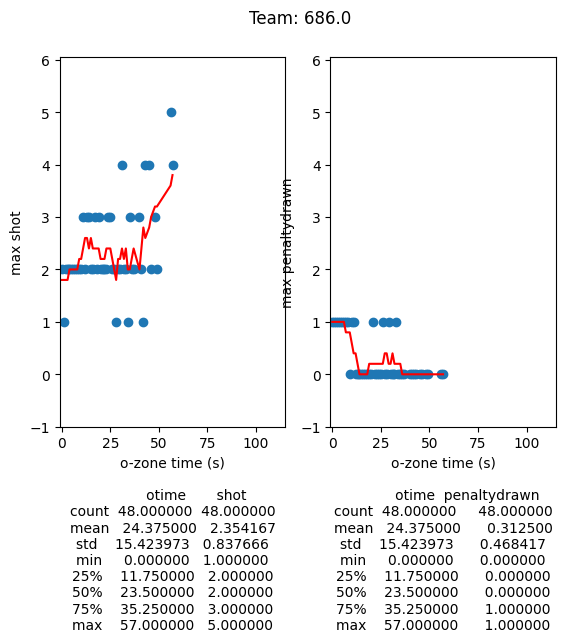

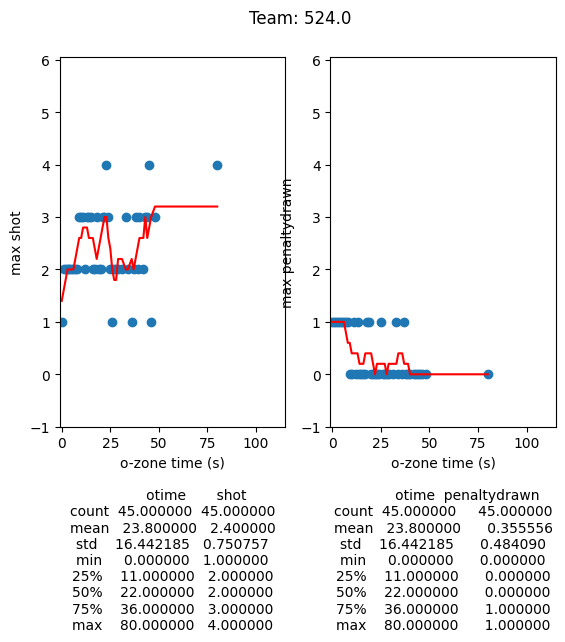

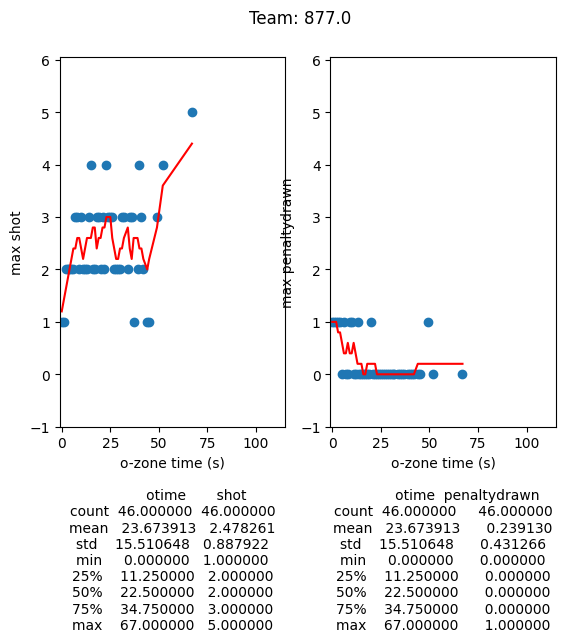

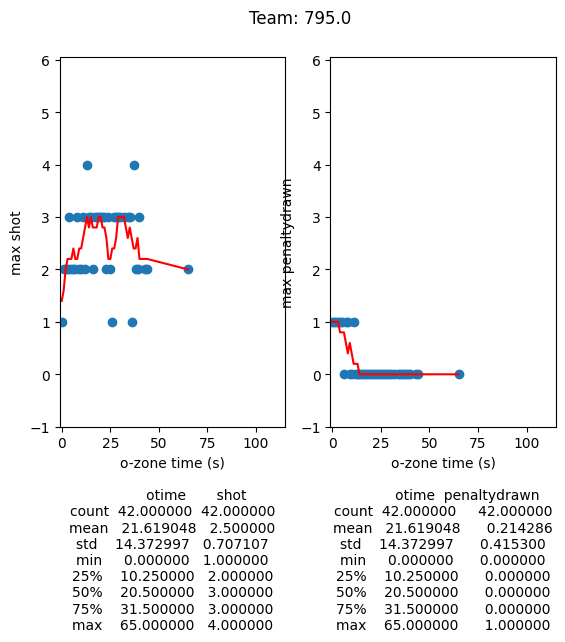

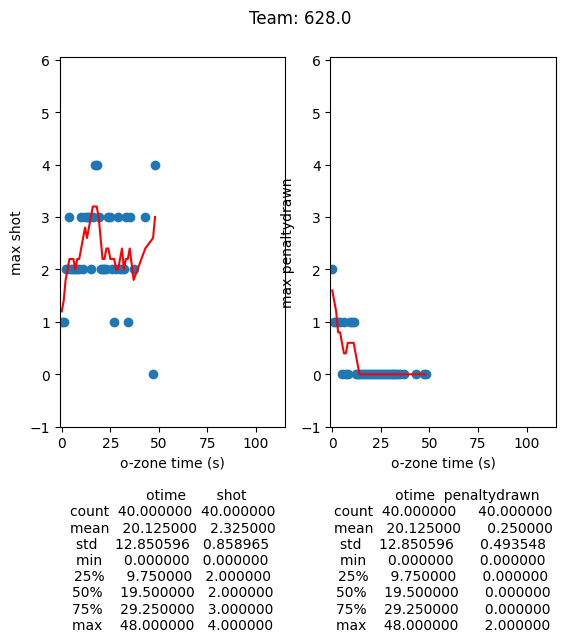

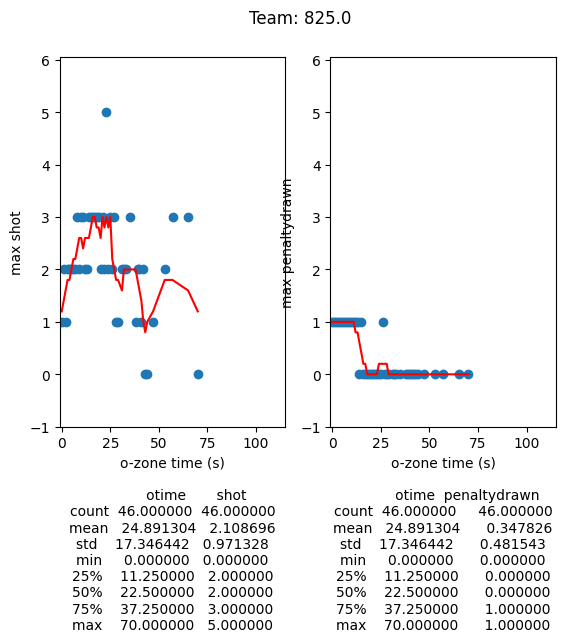

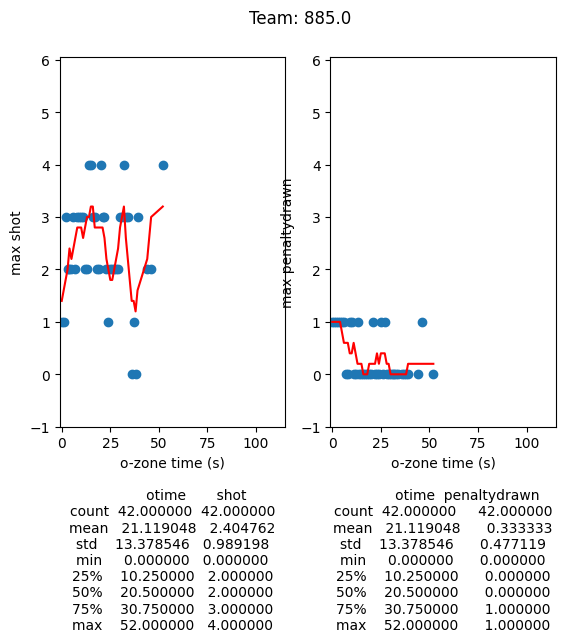

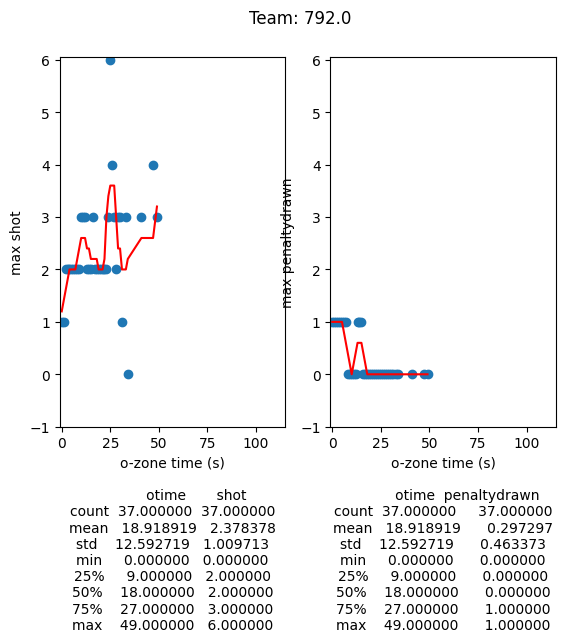

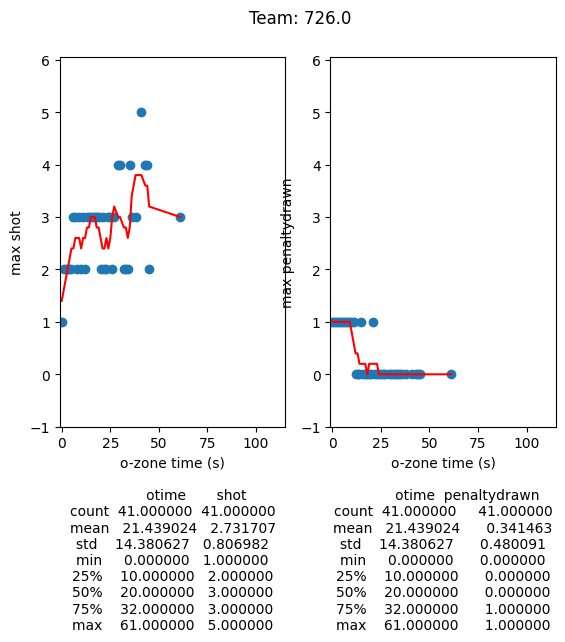

In [93]:
def collapseMaxEventsCount(arr):
    totals = defaultdict(lambda: 0)
    for otime, xg in arr:
        factor = 1
        totals[round(otime * factor, 0) / factor] = max(xg, totals[round(otime, 0)])
    
    return [[otime, xg] for otime, xg in totals.items()]

teamCount = defaultdict(lambda: defaultdict(list))
for game in gameDict:
    for team in gameDict[game]:
        for event_type in ADVANTAGEOUS_EVENTS:
            teamCount[team][event_type].extend([[otime, xg[event_type]] for otime, xg in gameDictEvents[game][team] if xg != 0])

memoizedMaxEvents = defaultdict(list)
windowSize = 5
for team in teamCount:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"Team: {team}")
    for idx, event_type in enumerate(ADVANTAGEOUS_EVENTS):
        dataArr = collapseMaxEventsCount(teamCount[team][event_type])
        memoizedMaxEvents[event_type] = memoizedMaxEvents[event_type] + dataArr

        data = np.array(sorted(dataArr, key=lambda x: x[0]))
        description = pd.DataFrame(dataArr, columns=["otime", event_type]).describe()
        paddedData = np.pad([y[1] for y in (data)], (windowSize//2, windowSize-1-windowSize//2), mode='edge')
        ma_vec = np.convolve(paddedData, np.ones((windowSize,))/windowSize, mode='valid')

        axs[idx].scatter([x[0] for x in data], [y[1] for y in data])
        axs[idx].plot([x[0] for x in data], ma_vec, "r")
        axs[idx].set_xlim(-1, 115)
        axs[idx].set_ylim(-1, 6.05)
        axs[idx].set_xlabel(f"o-zone time (s)\n\n{description}")
        axs[idx].set_ylabel(f"max {event_type}")

for event_type in ADVANTAGEOUS_EVENTS:
    cumulxg_df = pd.DataFrame(memoizedMaxEvents[event_type], columns=["otime", "events"]).describe()
    print(f'Total Stats\n{cumulxg_df}')



In [94]:
# Determining Averages
xg_key = 'xg_allattempts' if IS_2024 else 'xg'

## O-zone time
### Mean O-zone Time -> output should be dict[int, float] -> team name mapping to mean
fullTeamOzoneData = defaultdict(lambda: [0, 0])
fullTeamxGData = defaultdict(lambda: [0, 0])
fullTeamMaxxGData = defaultdict(lambda: 0)
for game in gameDict:
    for team in gameDict[game]:
        for ozone_event, xg_event in gameDict[game][team]:
            if xg_event != 0:
                fullTeamMaxxGData[team] = max(fullTeamMaxxGData[team], xg_event)
                fullTeamOzoneData[team][0] += ozone_event
                fullTeamOzoneData[team][1] += 1
                fullTeamxGData[team][0] += xg_event
                fullTeamxGData[team][1] += 1

meanOzoneData = defaultdict(lambda: 0)
meanxGData = defaultdict(lambda: 0)
for idx, team in enumerate(fullTeamOzoneData):
    meanOzoneData[team] = fullTeamOzoneData[team][0] / fullTeamOzoneData[team][1]
    meanxGData[team] = fullTeamxGData[team][0] / fullTeamxGData[team][1]

fullTeamshotsData = defaultdict(lambda: [0, 0])
fullTeampenaltiesData = defaultdict(lambda: [0, 0])
for game in gameDictEvents:
    for team in gameDictEvents[game]:
        for ozone_event, event_dict in gameDictEvents[game][team]:
            for event, xg_event in event_dict.items():
                if xg_event == 0:
                    continue

                if event == "shot":
                    fullTeamshotsData[team][0] += xg_event
                    fullTeamshotsData[team][1] += 1
                else:
                    fullTeampenaltiesData[team][0] += xg_event
                    fullTeampenaltiesData[team][1] += 1

meanShotsData = defaultdict(lambda: 0)
for idx, team in enumerate(fullTeamshotsData):
    meanShotsData[team] = fullTeamshotsData[team][0] / fullTeamshotsData[team][1]

meanPenaltiesData = defaultdict(lambda: 0)
for idx, team in enumerate(fullTeampenaltiesData):
    meanPenaltiesData[team] = fullTeampenaltiesData[team][0] / fullTeampenaltiesData[team][1]

fullTeamMaxShotxGData = defaultdict(lambda: 0)
for game in gameDict:
    for team in gameDict[game]:
        teamGameDF = df[
            (df['gameid'] == game) & (df['teaminpossession'] == team) & 
            (df['eventname'] == "shot") & (df['xadjcoord'] >= 25)
        ]
        fullTeamMaxShotxGData[team] = max(fullTeamMaxShotxGData[team], teamGameDF[xg_key].max())

In [95]:
import statistics

# Calculate Medians
teamOzoneData = defaultdict(list)
teamxGData = defaultdict(list)
teamShotsData = defaultdict(list)
teamPenaltiesData = defaultdict(list)
for game in gameDict:
    for team in gameDict[game]:
        teamOzoneData[team].extend(
            [
                ozone_event 
                for ozone_event, xg_event 
                in gameDict[game][team] 
                if xg_event != 0
            ]
        )

        teamxGData[team].extend(
            [
                xg_event 
                for _, xg_event 
                in gameDict[game][team] 
                if xg_event != 0
            ]
        )

        teamShotsData[team].extend(
            [
                xg_event["shot"] 
                for _, xg_event 
                in gameDictEvents[game][team]
            ]
        )

        teamPenaltiesData[team].extend(
            [
                xg_event["penaltydrawn"] 
                for _, xg_event 
                in gameDictEvents[game][team]
            ]
        )

medianOzoneData = defaultdict(lambda: 0)
medianxGData = defaultdict(lambda: 0)
medianShotsData = defaultdict(lambda: 0)
medianPenaltiesData = defaultdict(lambda: 0)
for team in teamOzoneData:
    medianOzoneData[team] = statistics.median(teamOzoneData[team])
    medianxGData[team] = statistics.median(teamxGData[team])
    medianShotsData[team] = statistics.median(teamShotsData[team])
    medianPenaltiesData[team] = statistics.median(teamPenaltiesData[team])

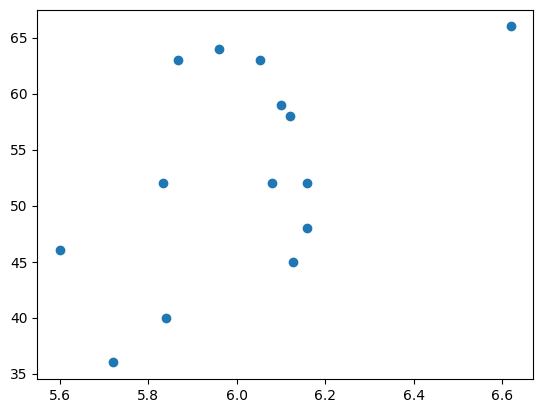

In [96]:
# mean ozone time against mean xg per shifts / mean number of shots per shift -> mean xg per shot
# plt.scatter([x for _, x in meanOzoneData.items()], [y / meanShotsData[team] for team, y in meanxGData.items()])

# mean ozone time against mean xg per shift
# plt.scatter([x for _, x in meanOzoneData.items()], [y for _, y in meanxGData.items()])

# mean ozone time against mean xg per shift out of max xg per shift
# plt.scatter([x for _, x in meanOzoneData.items()], [y / fullTeamMaxxGData[team] for team, y in meanxGData.items()])

# mean ozone time against mean xg per shot out of max xg per shot
# plt.scatter([x for _, x in meanOzoneData.items()], [(y / meanShotsData[team]) / fullTeamMaxShotxGData[team] for team, y in meanxGData.items()])

# median ozone time against median xg per shot out of max xg per shot
# plt.scatter([x for _, x in medianOzoneData.items()], [(y / meanShotsData[team]) / fullTeamMaxShotxGData[team] for team, y in medianxGData.items()])

# median ozone time against max xg per shift
# plt.scatter([x for _, x in medianOzoneData.items()], [fullTeamMaxShotxGData[team] for team in fullTeamMaxShotxGData])

# median ozone time against cumulative shots
# plt.scatter([x for _, x in medianOzoneData.items()], [sum(teamShotsData[team]) for team in teamShotsData])

# median ozone time against cumulative drawn penalties
plt.scatter([x for _, x in medianOzoneData.items()], [sum(teamPenaltiesData[team]) for team in teamPenaltiesData])

# print(meanShotsData)
# print(meanPenaltiesData)
# print(meanOzoneData)
# print(meanxGData)
# print(fullTeamMaxxGData)
# print(fullTeamMaxShotxGData)
# print(medianOzoneData)
# print(medianxGData)
# print(medianShotsData)
# print(medianPenaltiesData)

In [97]:
returnableData = []
for team in meanShotsData:
    returnableData.append(
        {
            "teamId": team,
            "meanOzoneTime": meanOzoneData[team],
            "medianOzoneTime": medianOzoneData[team],
            "meanxGPerShift": meanxGData[team],
            "medianxGPerShift": medianxGData[team],
            "meanShotsPerShift": meanShotsData[team],
            "medianShotsPerShift": medianShotsData[team],
            "meanPenaltiesPerShift": meanPenaltiesData[team],
            "medianPenaltiesPerShift": medianPenaltiesData[team],
            "maxxGPerShift": fullTeamMaxxGData[team],
            "maxxGPerShot": fullTeamMaxShotxGData[team],
            "meanxGPerShot": meanxGData[team] / meanShotsData[team],
            "meanxGPerShiftOutOfMaxxGPerShift": meanxGData[team] / fullTeamMaxxGData[team],
            "meanxGPerShotOutOfMaxxGPerShot": (meanxGData[team] / meanShotsData[team]) / fullTeamMaxShotxGData[team],
            "medianxGPerShotOutOfMaxxGPerShot": (medianxGData[team] / meanShotsData[team]) / fullTeamMaxShotxGData[team]
        }
    )

returnableDF = pd.DataFrame(returnableData)
returnableDF.to_csv(f"summarizedLINHAC{2024 if IS_2024 else 2023}Data.csv", index=False)
returnableDF

teamId  meanOzoneTime  medianOzoneTime  meanxGPerShift  medianxGPerShift  \
0    634.0       8.438438          6.16000        0.053509          0.017869   
1    855.0       8.484732          6.12000        0.055281          0.019513   
2    503.0       8.609323          6.10000        0.063517          0.023595   
3    869.0       8.205275          5.96000        0.057169          0.019127   
4    814.0       7.603391          5.60000        0.056983          0.021077   
5    686.0       9.349484          6.62000        0.066220          0.026590   
6    524.0       8.343367          5.83335        0.059380          0.022560   
7    877.0       8.298082          6.16000        0.053222          0.020089   
8    795.0       8.034643          5.72000        0.051596          0.019286   
9    628.0       7.893113          6.12665        0.051831          0.018440   
10   825.0       8.573341          6.08000        0.055019          0.016134   
11   885.0       7.966523          6.05330        0.059023          0.022230   
12   792.0       8.073535          5.84000        0.057350          0.017666   
13   726.0       8.150732          5.86670        0.056303          0.019478   

    meanShotsPerShift  medianShotsPerShift  meanPenaltiesPerShift  \
0            1.155153                  0.0               1.000000   
1            1.141361                  0.0               1.000000   
2            1.197876                  0.0               1.000000   
3            1.180344                  0.0               1.000000   
4            1.184512                  0.0               1.000000   
5            1.185950                  0.0               1.000000   
6            1.191849                  0.0               1.000000   
7            1.199798                  0.0               1.000000   
8            1.195560                  0.0               1.000000   
9            1.165406                  0.0               1.022727   
10           1.176670                  0.0               1.000000   
11           1.184584                  0.0               1.000000   
12           1.187430                  0.0               1.000000   
13           1.169507                  0.0               1.000000   

    medianPenaltiesPerShift  maxxGPerShift  maxxGPerShot  meanxGPerShot  \
0                       0.0       0.809618      0.809618       0.046322   
1                       0.0       0.749067      0.627943       0.048434   
2                       0.0       0.982906      0.619236       0.053025   
3                       0.0       0.896192      0.896192       0.048434   
4                       0.0       0.812661      0.690224       0.048107   
5                       0.0       0.819820      0.704890       0.055837   
6                       0.0       0.771834      0.771834       0.049822   
7                       0.0       0.985163      0.722066       0.044359   
8                       0.0       1.000605      0.882324       0.043156   
9                       0.0       0.764308      0.740613       0.044475   
10                      0.0       1.078449      0.724420       0.046758   
11                      0.0       1.148333      0.776525       0.049826   
12                      0.0       0.658831      0.575761       0.048298   
13                      0.0       0.817970      0.725877       0.048143   

    meanxGPerShiftOutOfMaxxGPerShift  meanxGPerShotOutOfMaxxGPerShot  \
0                           0.066092                        0.057215   
1                           0.073800                        0.077132   
2                           0.064622                        0.085630   
3                           0.063791                        0.054044   
4                           0.070119                        0.069697   
5                           0.080774                        0.079214   
6                           0.076934                        0.064550   
7                           0.054024                        0.061